In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_keywords = pd.read_csv('datasets/df_agri_keywords.csv')
df_ner = pd.read_csv('datasets/df_agri_ner.csv')
df_sentiment = pd.read_csv('datasets/processed_results.csv')

In [3]:
# Add columns to df_final
ner_cols = ['actor_persons', 'actor_organizations', 'actor_locations']
sentiment_cols = ['sentiment', 'sentiment_confidence'] 
df_keywords[ner_cols] = df_ner[ner_cols]
df_keywords[sentiment_cols] = df_sentiment[sentiment_cols]
df_final = df_keywords
df_final.to_csv('datasets/df_agri_final.csv', index=False, encoding='utf-8')

In [14]:
df_final.head()

,channel_title,channel_name,country,segment_id,segment_start,segment_end,duration_seconds,num_keywords,avg_density,themes,...,secondary_categories,text_type,keywords,keywords_filtered,nouns_in_keywords,actor_persons,actor_organizations,actor_locations,sentiment,sentiment_confidence
0,France 2,france2,france,5788,2025-12-03 06:34:04.031 +0100,2025-12-03 06:36:02.025 +0100,118,18,13.4,", attenuation_climatique_solutions_indirectes,...",...,['energy'],segment,"['voyez', 'radiologues', 'entraîne activement ...","['entraîne activement lucie robert', 'stations...","['concurrence', 'stations', 'résultats', 'dire...",['mathieu'],[],"['france', 'doubs']",positive,0.859769
1,M6,m6,france,3445,2025-11-17 15:20:24.048 +0100,2025-11-17 15:21:26.064 +0100,62,4,5.3,", biodiversite_causes_indirectes, changement_c...",...,[],segment,"['enseigne travaille', 'va voir si', 'david', ...","['enseigne travaille', 'cours', 'prochaine car...","['temps', 'directeurs', 'retraites', 'site', '...","['david', 'christo popov', 'thomas fersen']",[],['paris'],positive,0.851858
2,M6,m6,france,1379,2025-05-13 20:14:11.059 +0200,2025-05-13 20:15:50.004 +0200,99,8,8.1,"attenuation_climatique_solutions_indirectes, b...",...,[],segment,"['réglementations strictes imposées', 'essaie'...","['réglementations strictes imposées', 'parc na...","['heure', 'mérite', 'sympathie', 'euros', 'rég...","['saint-pierre', 'rouget rascasse rouge']",[],"['îles des caraïbes', 'parc national de port-c...",negative,0.928592
3,TF1,tf1,france,4852,2025-12-25 09:11:59.056 +0100,2025-12-25 09:13:11.082 +0100,72,15,17.2,"adaptation_climatique_solutions, attenuation_c...",...,[],segment,"['allez pouvoir', 'froid', 'herbes', 'myrtille...","['certains papiers', 'plantes', 'déchets', 'hu...","['année', 'pommes', 'andalou', 'choses', 'limi...",['noël sinon'],[],[],negative,0.488315
4,France 2,france2,france,5744,2025-11-30 07:36:06.090 +0100,2025-11-30 07:38:37.058 +0100,151,11,10.5,"biodiversite_causes, biodiversite_concepts_gen...",...,[],segment,"['voyez', 'côté alpes', 'météo', 'peu gêné', '...","['côté alpes', 'météo', 'extérieur', 'choses',...","['météo', 'choses', 'extérieur', 'règles', 'en...","['sébastien thomas regardez', 'cana vérandas',...",[],"['alsace', 'etats-unis', 'pyrénées', ""l' illin...",positive,0.851335


In [15]:
df_final.head(10)

,channel_title,channel_name,country,segment_id,segment_start,segment_end,duration_seconds,num_keywords,avg_density,themes,...,secondary_categories,text_type,keywords,keywords_filtered,nouns_in_keywords,actor_persons,actor_organizations,actor_locations,sentiment,sentiment_confidence
0,France 2,france2,france,5788,2025-12-03 06:34:04.031 +0100,2025-12-03 06:36:02.025 +0100,118,18,13.4,", attenuation_climatique_solutions_indirectes,...",...,['energy'],segment,"['voyez', 'radiologues', 'entraîne activement ...","['entraîne activement lucie robert', 'stations...","['concurrence', 'stations', 'résultats', 'dire...",['mathieu'],[],"['france', 'doubs']",positive,0.859769
1,M6,m6,france,3445,2025-11-17 15:20:24.048 +0100,2025-11-17 15:21:26.064 +0100,62,4,5.3,", biodiversite_causes_indirectes, changement_c...",...,[],segment,"['enseigne travaille', 'va voir si', 'david', ...","['enseigne travaille', 'cours', 'prochaine car...","['temps', 'directeurs', 'retraites', 'site', '...","['david', 'christo popov', 'thomas fersen']",[],['paris'],positive,0.851858
2,M6,m6,france,1379,2025-05-13 20:14:11.059 +0200,2025-05-13 20:15:50.004 +0200,99,8,8.1,"attenuation_climatique_solutions_indirectes, b...",...,[],segment,"['réglementations strictes imposées', 'essaie'...","['réglementations strictes imposées', 'parc na...","['heure', 'mérite', 'sympathie', 'euros', 'rég...","['saint-pierre', 'rouget rascasse rouge']",[],"['îles des caraïbes', 'parc national de port-c...",negative,0.928592
3,TF1,tf1,france,4852,2025-12-25 09:11:59.056 +0100,2025-12-25 09:13:11.082 +0100,72,15,17.2,"adaptation_climatique_solutions, attenuation_c...",...,[],segment,"['allez pouvoir', 'froid', 'herbes', 'myrtille...","['certains papiers', 'plantes', 'déchets', 'hu...","['année', 'pommes', 'andalou', 'choses', 'limi...",['noël sinon'],[],[],negative,0.488315
4,France 2,france2,france,5744,2025-11-30 07:36:06.090 +0100,2025-11-30 07:38:37.058 +0100,151,11,10.5,"biodiversite_causes, biodiversite_concepts_gen...",...,[],segment,"['voyez', 'côté alpes', 'météo', 'peu gêné', '...","['côté alpes', 'météo', 'extérieur', 'choses',...","['météo', 'choses', 'extérieur', 'règles', 'en...","['sébastien thomas regardez', 'cana vérandas',...",[],"['alsace', 'etats-unis', 'pyrénées', ""l' illin...",positive,0.851335
5,France 2,france2,france,2000,2025-05-07 06:42:01.096 +0200,2025-05-07 06:44:57.032 +0200,176,22,16.0,", adaptation_climatique_solutions_indirectes, ...",...,[],report,"['situation plus instable', 'vient vraiment dé...","['situation plus instable', 'choses', 'seul en...","['choses', 'plantes', 'part', 'espace', 'sud',...","['costaud samedi samedi', 'sébastien <', 'paul...",['france télévisions'],"['douai', 'suède', 'lille', 'france', 'rennes'...",positive,0.852669
6,M6,m6,france,3667,2025-12-09 13:18:27.001 +0100,2025-12-09 13:19:43.024 +0100,76,16,23.6,", adaptation_climatique_solutions_indirectes, ...",...,['mobility_transport'],segment,"['spectacle', 'ligne', 'peu tous', 'surtout ch...","['spectacle', 'ligne', 'mots', 'problématiques...","['chaise', 'évident', 'année', 'frontalement',...","['thibaud le floch', 'gustave kervern', 'jacqu...",[],"['chine', 'chili']",negative,0.443744
7,France 3-idf,fr3-idf,france,3499,2025-12-31 12:10:01.042 +0100,2025-12-31 12:11:44.095 +0100,103,11,14.2,", biodiversite_concepts_generaux_indirectes, c...",...,[],segment,"['cochon', 'france', 'va dire', 'bord mer', 'é...","['cochon', 'bord mer', 'équipes', 'mer station...","['traditions', 'cochon', 'production', 'météo'...","['saint gosier félix', 'bertrand']",[],"['guadeloupe', 'de france', 'france']",positive,0.821654
8,M6,m6,france,830,2025-03-21 20:08:42.054 +0100,2025-03-21 20:11:03.066 +0100,141,32,23.3,", attenuation_climatique_solutions, biodiversi...",...,['energy'],segment,"['cinq ans', 'a comme ambition chez bell', 'ra...","['cinq ans', 'a comme ambition chez bell', 'ef...","['tests', 'effets', 'préservatif', 'peine', 'd...",['arthur mario'],['bell'],['france'],negative,0.900346


## Analysis

In [4]:
# Configuration pour les visualisations
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

# Vérifier les dimensions du dataset
print(f"Nombre de segments: {len(df_final)}")
print(f"Nombre de colonnes: {len(df_final.columns)}")
print(f"\nColonnes disponibles:")
print(df_final.columns.tolist())

Nombre de segments: 2565
Nombre de colonnes: 22

Colonnes disponibles:
['channel_title', 'channel_name', 'country', 'segment_id', 'segment_start', 'segment_end', 'duration_seconds', 'num_keywords', 'avg_density', 'themes', 'report_text', 'category', 'secondary_categories', 'text_type', 'keywords', 'keywords_filtered', 'nouns_in_keywords', 'actor_persons', 'actor_organizations', 'actor_locations', 'sentiment', 'sentiment_confidence']


### Question 1: Quels sont les modèles agricoles représentés dans les reportages ?

Nous allons analyser la colonne `themes` pour identifier les modèles agricoles et thématiques environnementales abordés.

In [5]:
# Analyser les thèmes
import ast
from collections import Counter

# Fonction pour extraire les thèmes
def extract_themes(themes_str):
    if pd.isna(themes_str) or themes_str == '':
        return []
    # Nettoyer et séparer les thèmes
    themes_str = str(themes_str).strip(',').strip()
    if themes_str:
        return [theme.strip() for theme in themes_str.split(',') if theme.strip()]
    return []

# Extraire tous les thèmes
all_themes = []
for themes in df_final['themes']:
    all_themes.extend(extract_themes(themes))

# Compter les thèmes
theme_counts = Counter(all_themes)
print(f"Nombre total de thèmes uniques: {len(theme_counts)}")
print(f"\nTop 20 des thèmes les plus fréquents:")
for theme, count in theme_counts.most_common(20):
    print(f"  {theme}: {count}")

Nombre total de thèmes uniques: 22

Top 20 des thèmes les plus fréquents:
  biodiversite_concepts_generaux_indirectes: 2041
  changement_climatique_constat_indirectes: 1875
  ressources_indirectes: 1559
  biodiversite_concepts_generaux: 1289
  ressources: 1201
  changement_climatique_constat: 1042
  changement_climatique_causes_indirectes: 1019
  biodiversite_causes: 977
  attenuation_climatique_solutions_indirectes: 857
  biodiversite_causes_indirectes: 792
  biodiversite_solutions: 726
  ressources_solutions_indirectes: 715
  changement_climatique_consequences: 693
  changement_climatique_consequences_indirectes: 681
  adaptation_climatique_solutions_indirectes: 679
  attenuation_climatique_solutions: 640
  ressources_solutions: 633
  changement_climatique_causes: 512
  biodiversite_solutions_indirectes: 496
  biodiversite_consequences_indirectes: 341


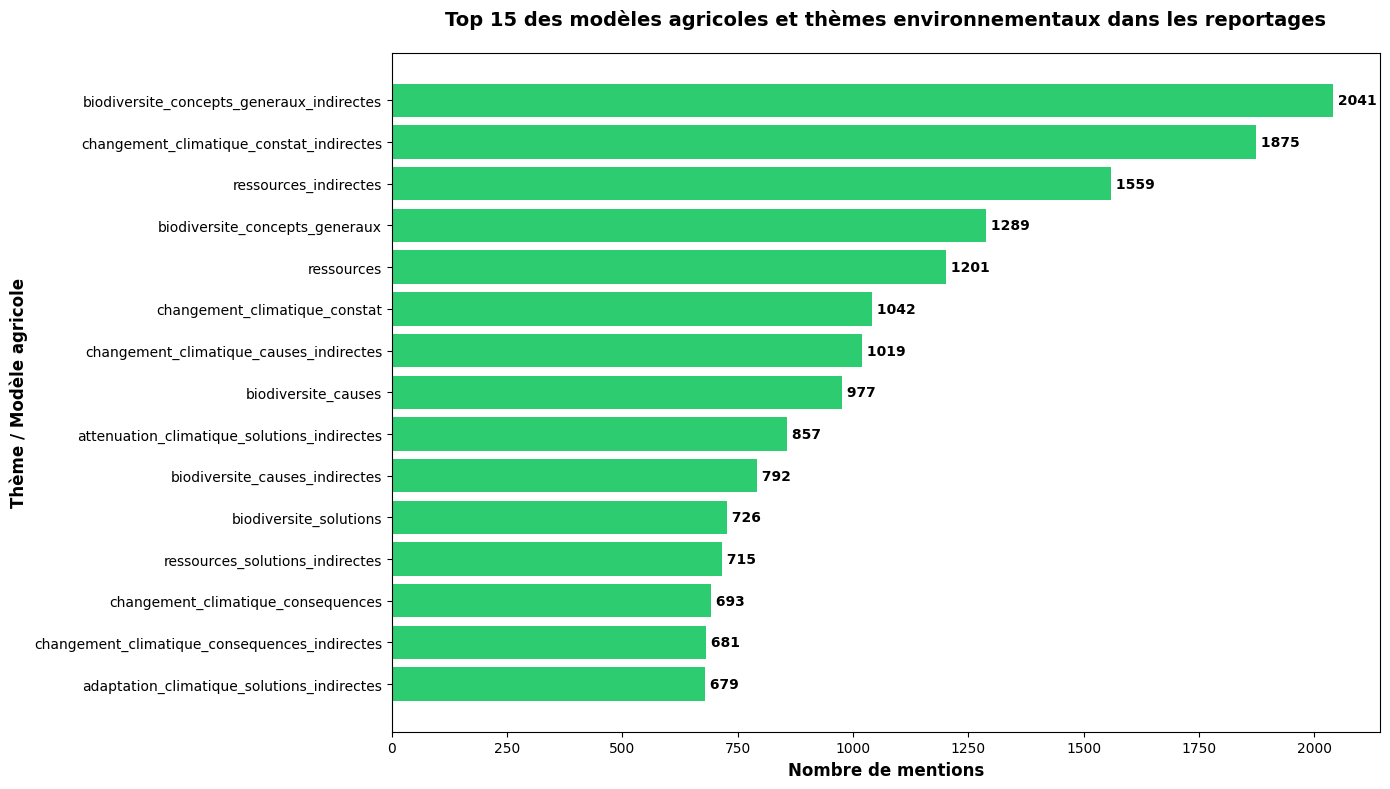

In [18]:
# Visualisation 1: Top 15 des modèles/thèmes agricoles
top_themes = theme_counts.most_common(15)
themes_df = pd.DataFrame(top_themes, columns=['Theme', 'Count'])

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.barh(themes_df['Theme'], themes_df['Count'], color='#2ecc71')
ax.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
ax.set_ylabel('Thème / Modèle agricole', fontsize=12, fontweight='bold')
ax.set_title('Top 15 des modèles agricoles et thèmes environnementaux dans les reportages', 
             fontsize=14, fontweight='bold', pad=20)
ax.invert_yaxis()

# Ajouter les valeurs sur les barres
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width)}', 
            ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

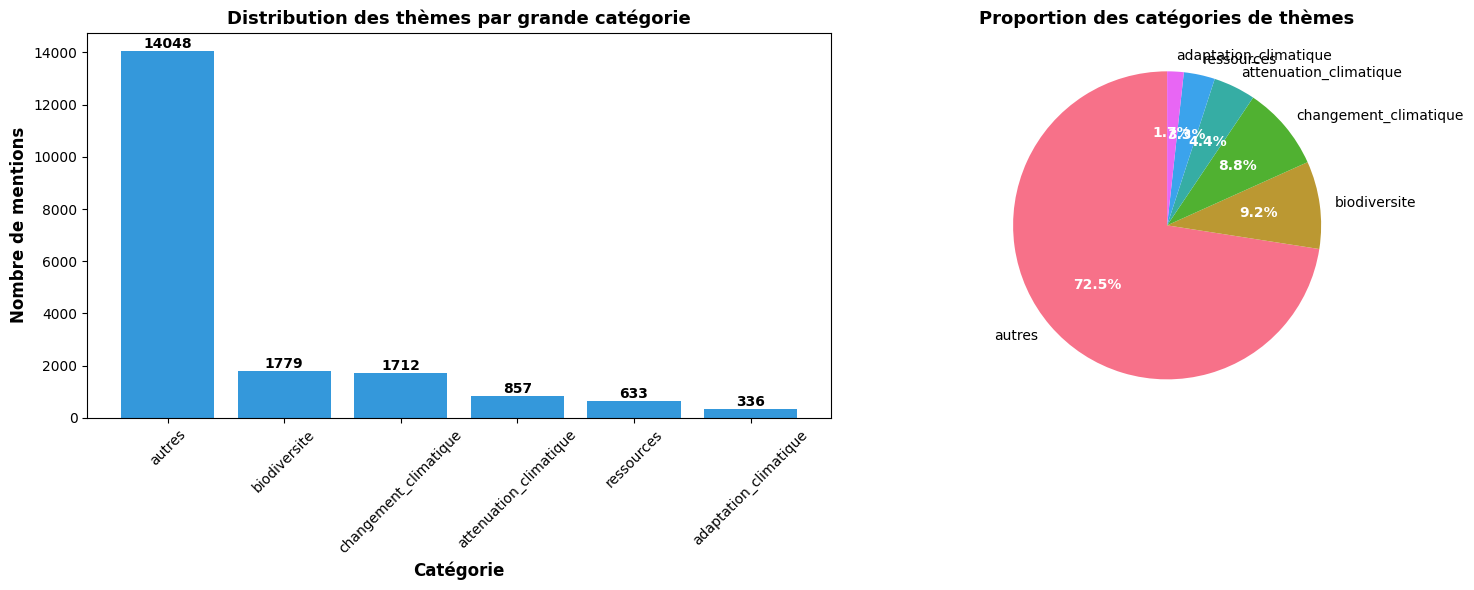

In [21]:
# Catégoriser les thèmes par grandes familles
categories_mapping = {
    'biodiversite': ['biodiversite_causes_indirectes', 'biodiversite_causes_directes', 
                     'biodiversite_consequences', 'biodiversite_solutions'],
    'changement_climatique': ['changement_climatique_causes_indirectes', 'changement_climatique_causes_directes',
                              'changement_climatique_consequences', 'changement_climatique_solutions'],
    'attenuation_climatique': ['attenuation_climatique_solutions_indirectes', 'attenuation_climatique_solutions_directes'],
    'adaptation_climatique': ['adaptation_climatique_solutions'],
    'ressources': ['ressources_consequences', 'ressources_causes_indirectes', 'ressources_solutions'],
    'pollution': ['pollution_causes_indirectes', 'pollution_causes_directes', 
                  'pollution_consequences', 'pollution_solutions']
}

# Créer un dictionnaire inversé pour mapper chaque thème à sa catégorie
theme_to_category = {}
for category, themes_list in categories_mapping.items():
    for theme in themes_list:
        theme_to_category[theme] = category

# Compter par catégorie
category_counts = Counter()
for theme, count in theme_counts.items():
    category = theme_to_category.get(theme, 'autres')
    category_counts[category] += count

# Visualisation des grandes catégories
cat_df = pd.DataFrame(category_counts.most_common(), columns=['Catégorie', 'Count'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Diagramme en barres
bars = ax1.bar(cat_df['Catégorie'], cat_df['Count'], color='#3498db')
ax1.set_xlabel('Catégorie', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de mentions', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des thèmes par grande catégorie', fontsize=13, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

# Diagramme circulaire
colors = sns.color_palette("husl", len(cat_df))
wedges, texts, autotexts = ax2.pie(cat_df['Count'], labels=cat_df['Catégorie'], 
                                     autopct='%1.1f%%', colors=colors,
                                     startangle=90)
ax2.set_title('Proportion des catégories de thèmes', fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

### Question 2: Quels sont les acteurs prenant la parole sur l'agriculture dans les médias en France ?

Nous allons analyser les colonnes `actor_persons` (personnes) et `actor_organizations` (organisations).

In [6]:
# Analyser les acteurs (personnes et organisations)

def extract_actors(actor_str):
    """Extrait les acteurs d'une chaîne de caractères (format liste Python)"""
    if pd.isna(actor_str) or actor_str == '' or actor_str == '[]':
        return []
    try:
        # Essayer de parser comme une liste Python
        actors = ast.literal_eval(actor_str)
        if isinstance(actors, list):
            return [str(actor).strip().strip("'\"") for actor in actors if actor]
        return []
    except:
        # Si échec, essayer de séparer par virgules
        return [actor.strip().strip("'\"[]") for actor in str(actor_str).split(',') if actor.strip()]

# Extraire toutes les personnes
all_persons = []
for persons in df_final['actor_persons']:
    all_persons.extend(extract_actors(persons))

# Extraire toutes les organisations
all_organizations = []
for orgs in df_final['actor_organizations']:
    all_organizations.extend(extract_actors(orgs))

# Compter les acteurs
person_counts = Counter(all_persons)
org_counts = Counter(all_organizations)

print(f"Nombre total de personnes uniques: {len(person_counts)}")
print(f"Nombre total d'organisations uniques: {len(org_counts)}")
print(f"\nTop 15 des personnes les plus mentionnées:")
for person, count in person_counts.most_common(15):
    print(f"  {person}: {count}")
print(f"\nTop 15 des organisations les plus mentionnées:")
for org, count in org_counts.most_common(15):
    print(f"  {org}: {count}")

Nombre total de personnes uniques: 3248
Nombre total d'organisations uniques: 345

Top 15 des personnes les plus mentionnées:
  donald trump: 81
  emmanuel macron: 51
  frédéric: 40
  ben: 31
  françois bayrou: 30
  philippe: 27
  mathieu: 26
  thomas: 25
  julia: 24
  guillaume: 22
  vladimir poutine: 22
  antoine: 22
  leclerc: 20
  françois: 18
  louis: 17

Top 15 des organisations les plus mentionnées:
  union européenne: 72
  assemblée nationale: 54
  tf1: 45
  mercosur: 41
  nestlé: 20
  unesco: 16
  renault: 14
  ufc: 14
  sncf: 12
  insee: 11
  otan: 10
  edf: 10
  peugeot: 7
  cfdt: 6
  volkswagen: 6


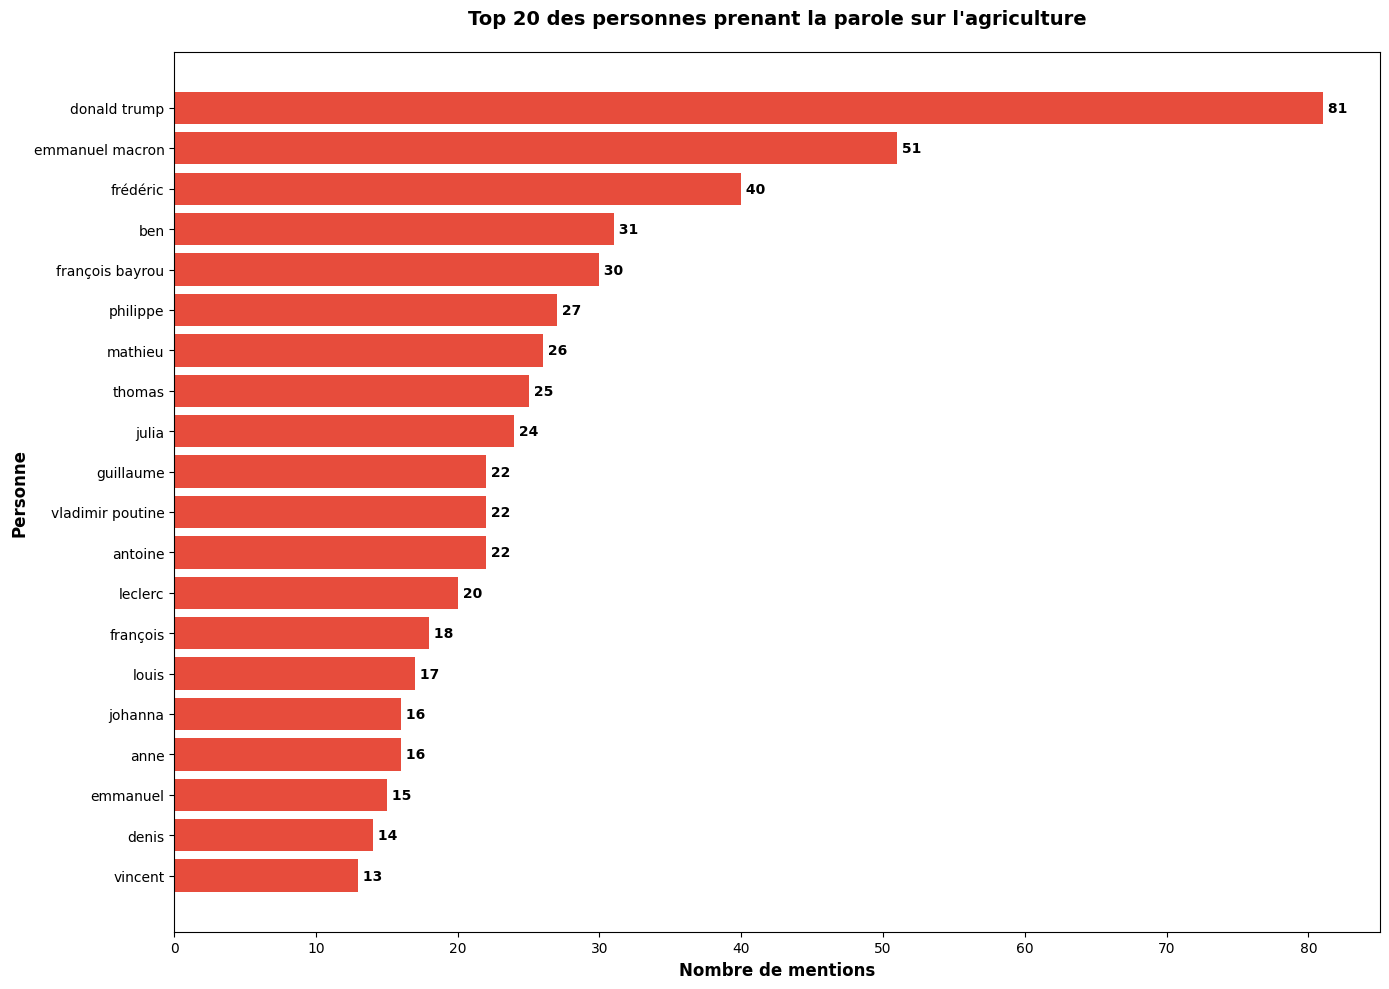

In [21]:
# Visualisation 2: Top des acteurs (personnes)
top_persons = person_counts.most_common(20)
if top_persons:
    persons_df = pd.DataFrame(top_persons, columns=['Personne', 'Count'])
    
    fig, ax = plt.subplots(figsize=(14, 10))
    bars = ax.barh(persons_df['Personne'], persons_df['Count'], color='#e74c3c')
    ax.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Personne', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 des personnes prenant la parole sur l\'agriculture', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    
    # Ajouter les valeurs
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f' {int(width)}', 
                ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée sur les personnes")

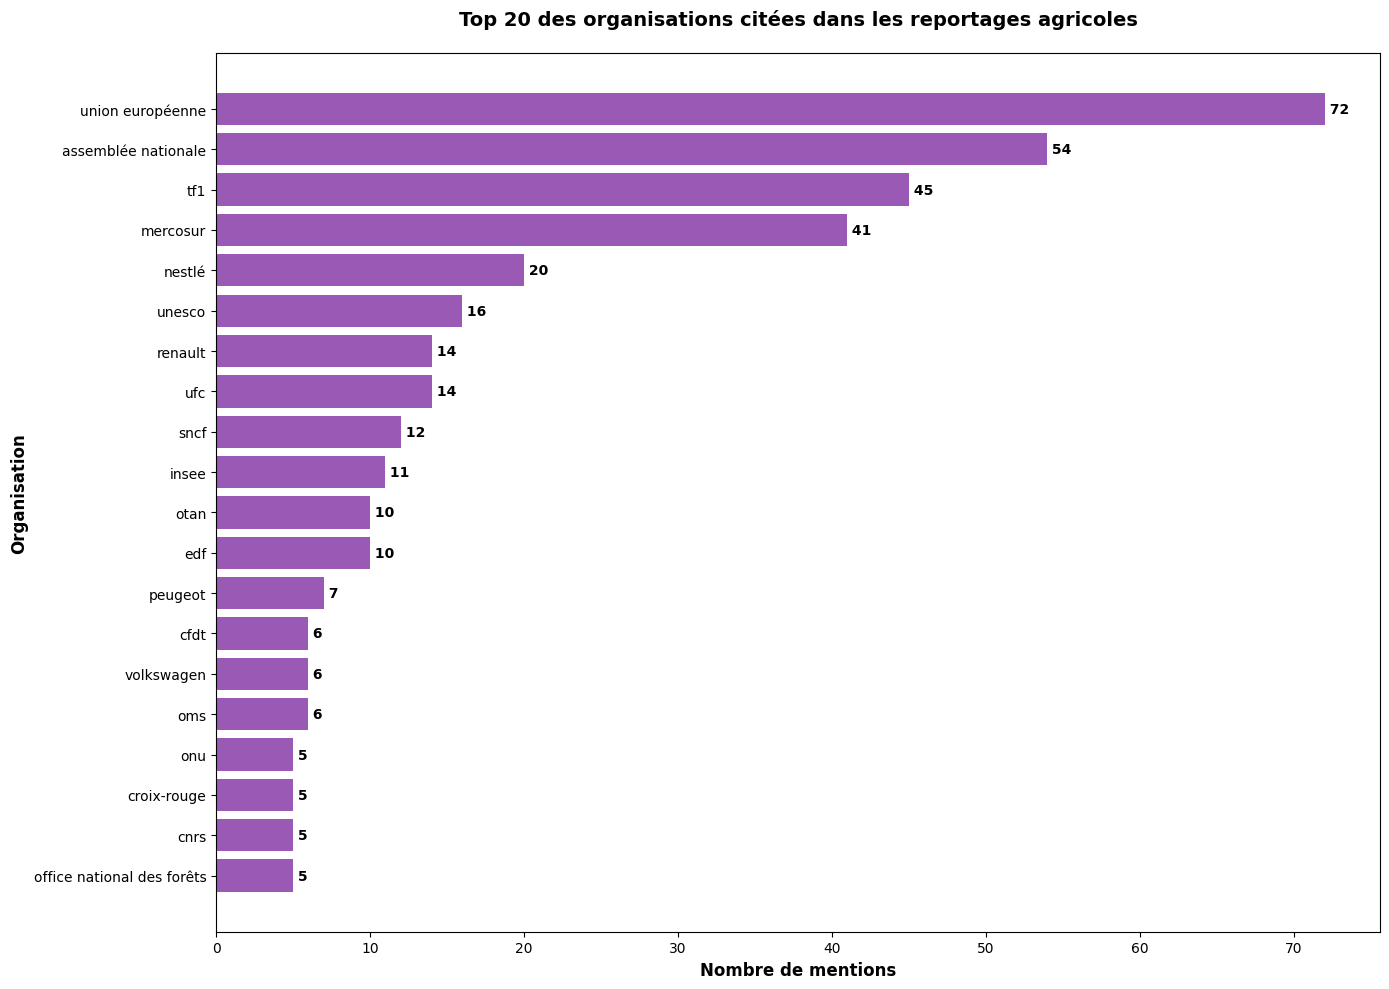

In [22]:
# Visualisation 3: Top des organisations
top_orgs = org_counts.most_common(20)
if top_orgs:
    orgs_df = pd.DataFrame(top_orgs, columns=['Organisation', 'Count'])
    
    fig, ax = plt.subplots(figsize=(14, 10))
    bars = ax.barh(orgs_df['Organisation'], orgs_df['Count'], color='#9b59b6')
    ax.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Organisation', fontsize=12, fontweight='bold')
    ax.set_title('Top 20 des organisations citées dans les reportages agricoles', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    
    # Ajouter les valeurs
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f' {int(width)}', 
                ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune donnée sur les organisations")

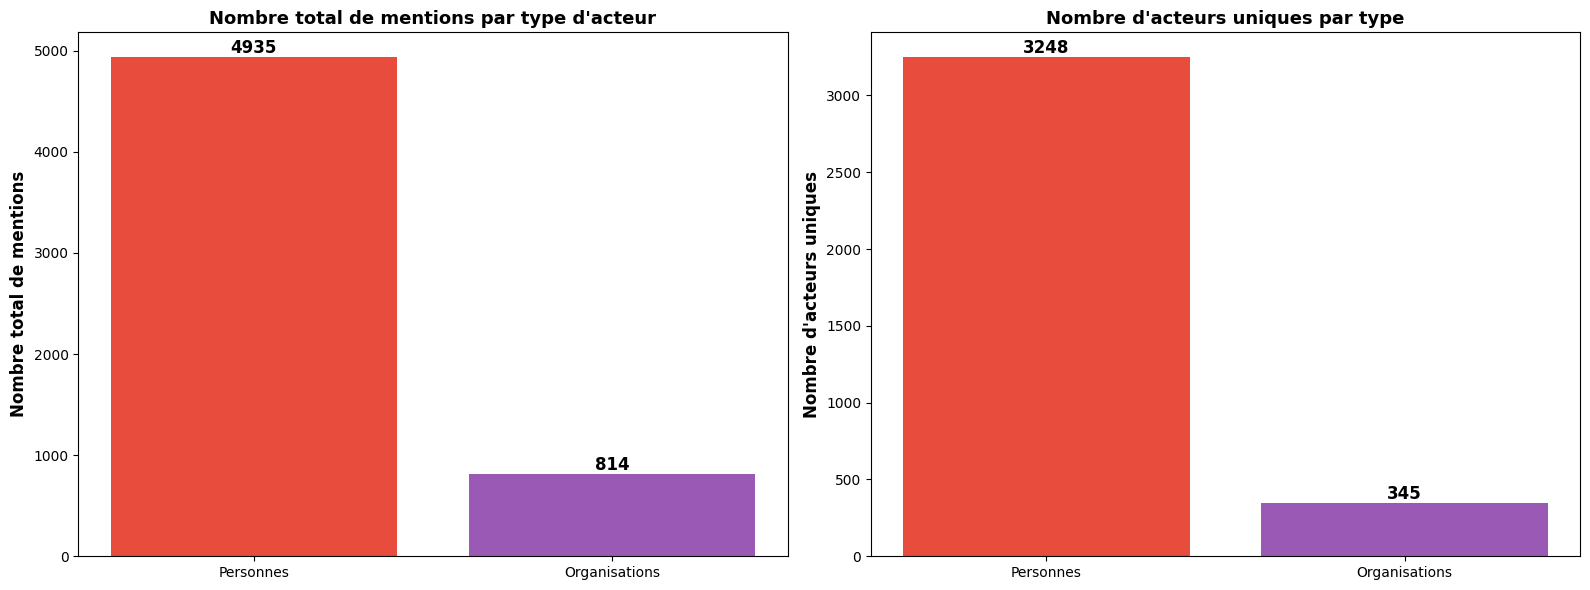

In [23]:
# Visualisation 4: Comparaison Personnes vs Organisations
actor_types = ['Personnes', 'Organisations']
actor_counts_data = [len(all_persons), len(all_organizations)]
unique_counts = [len(person_counts), len(org_counts)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Total des mentions
bars1 = ax1.bar(actor_types, actor_counts_data, color=['#e74c3c', '#9b59b6'])
ax1.set_ylabel('Nombre total de mentions', fontsize=12, fontweight='bold')
ax1.set_title('Nombre total de mentions par type d\'acteur', fontsize=13, fontweight='bold')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Acteurs uniques
bars2 = ax2.bar(actor_types, unique_counts, color=['#e74c3c', '#9b59b6'])
ax2.set_ylabel('Nombre d\'acteurs uniques', fontsize=12, fontweight='bold')
ax2.set_title('Nombre d\'acteurs uniques par type', fontsize=13, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

### Question 3: Quels sont les angles avec lesquels sont traités les sujets agricoles ?

Nous allons analyser:
1. Les mots-clés (`keywords_filtered`) pour identifier les angles de traitement
2. Le sentiment (`sentiment`) pour comprendre le ton des reportages
3. Les catégories secondaires (`secondary_categories`)

In [7]:
# Analyser les mots-clés pour identifier les angles de traitement
all_keywords = []
for keywords in df_final['keywords_filtered']:
    extracted = extract_actors(keywords)  # Réutiliser la fonction pour extraire les listes
    all_keywords.extend(extracted)

# Compter les mots-clés
keyword_counts = Counter(all_keywords)
print(f"Nombre total de mots-clés uniques: {len(keyword_counts)}")
print(f"\nTop 30 des mots-clés les plus fréquents:")
for keyword, count in keyword_counts.most_common(30):
    print(f"  {keyword}: {count}")

Nombre total de mots-clés uniques: 124076

Top 30 des mots-clés les plus fréquents:
  eau: 599
  matin: 588
  temps: 570
  production: 511
  monde: 494
  aujourd: 474
  jour: 456
  fin: 450
  moment: 442
  place: 439
  exemple: 435
  prix: 432
  mois: 423
  côté: 402
  pense: 391
  produits: 389
  sud: 370
  vie: 367
  pays: 363
  cas: 345
  fois: 343
  début: 333
  gens: 325
  nord: 317
  soir: 315
  cause: 312
  voit: 303
  heure: 301
  année: 299
  produit: 298


In [8]:
# Identifier les angles de traitement par catégories thématiques
angles_categories = {
    'Économie/Pouvoir d\'achat': ['prix', 'coût', 'économie', 'marché', 'euros', 'budget', 'argent', 
                                   'pouvoir achat', 'revenus', 'salaire', 'financier'],
    'Emploi': ['emploi', 'travail', 'chômage', 'métier', 'formation', 'embauche', 'travailleurs'],
    'Santé': ['santé', 'maladie', 'médecin', 'hôpital', 'soins', 'patient', 'alimentation'],
    'Environnement': ['environnement', 'écologie', 'pollution', 'climat', 'biodiversité', 
                      'nature', 'durable', 'vert'],
    'Réglementation/Normes': ['norme', 'règlement', 'loi', 'interdiction', 'autorisation', 
                              'réglementation', 'directive', 'législation'],
    'Mobilisation/Colère': ['colère', 'manifestation', 'protestation', 'mobilisation', 'grève', 
                            'blocage', 'agriculteurs'],
    'Technologie/Innovation': ['technologie', 'innovation', 'numérique', 'robot', 'digital', 
                               'moderne', 'nouveau']
}

# Compter les mots-clés par angle
angle_counts = {}
for angle, keywords_list in angles_categories.items():
    count = 0
    for keyword in keyword_counts.keys():
        keyword_lower = keyword.lower()
        if any(kw in keyword_lower for kw in keywords_list):
            count += keyword_counts[keyword]
    angle_counts[angle] = count

angle_df = pd.DataFrame(list(angle_counts.items()), columns=['Angle', 'Count'])
angle_df = angle_df.sort_values('Count', ascending=False)

print("\nDistribution des angles de traitement:")
print(angle_df)


Distribution des angles de traitement:
                      Angle  Count
0  Économie/Pouvoir d'achat   5529
3             Environnement   3251
4     Réglementation/Normes   2071
2                     Santé   1658
1                    Emploi   1499
6    Technologie/Innovation    900
5       Mobilisation/Colère    544


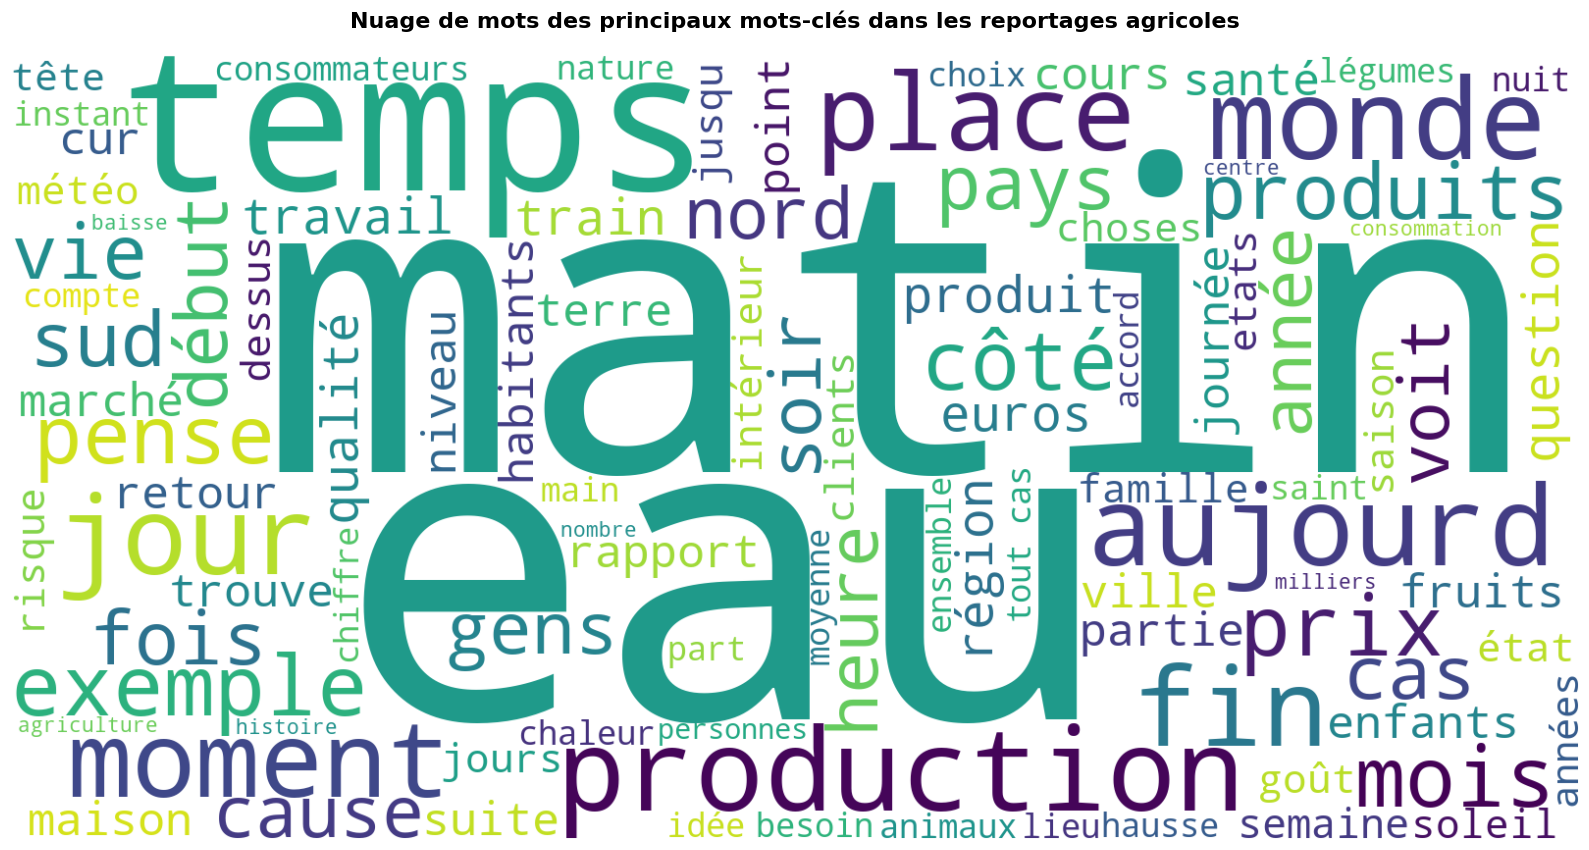

In [9]:
# Visualisation 5: Nuage de mots des mots-clés
from wordcloud import WordCloud

# Créer un dictionnaire de fréquences pour le nuage de mots
keyword_freq = dict(keyword_counts.most_common(100))

fig, ax = plt.subplots(figsize=(16, 10))
wordcloud = WordCloud(width=1600, height=800, 
                     background_color='white',
                     colormap='viridis',
                     relative_scaling=0.5,
                     min_font_size=10).generate_from_frequencies(keyword_freq)

ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')
ax.set_title('Nuage de mots des principaux mots-clés dans les reportages agricoles', 
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

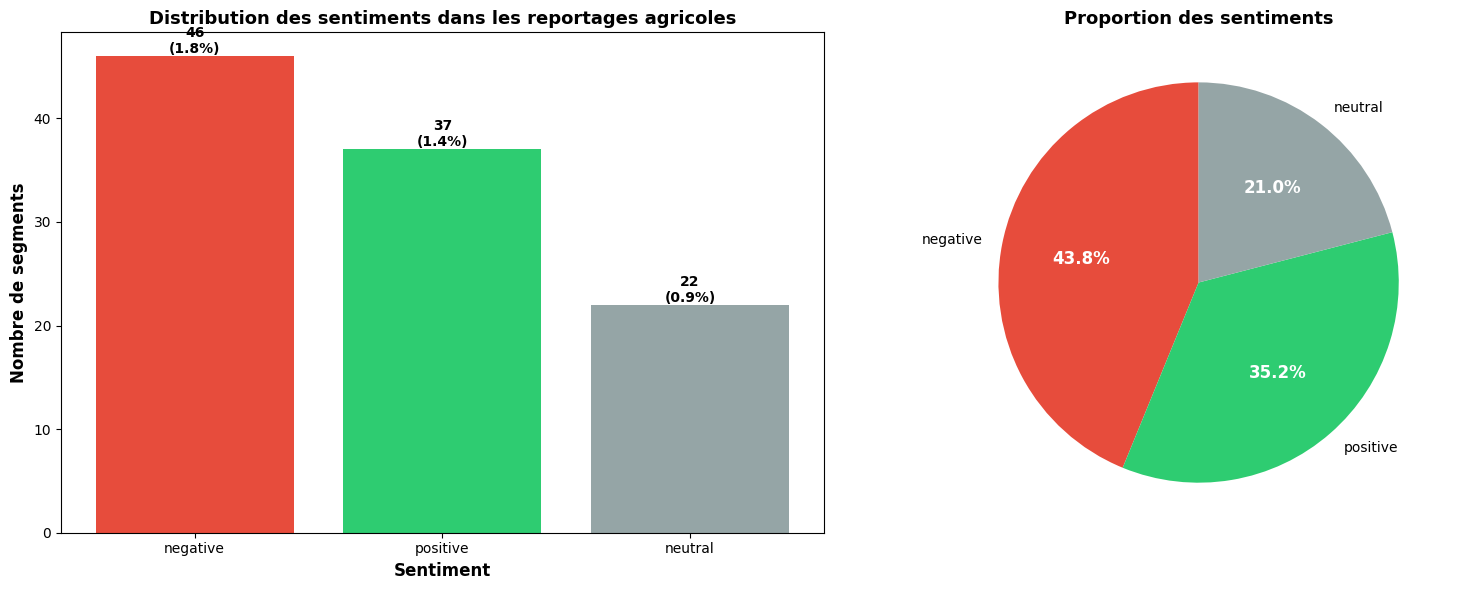

In [10]:
# Visualisation 6: Distribution des sentiments
sentiment_dist = df_final['sentiment'].value_counts()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Graphique en barres
colors_sent = {'positive': '#2ecc71', 'negative': '#e74c3c', 'neutral': '#95a5a6'}
bar_colors = [colors_sent.get(sent, '#3498db') for sent in sentiment_dist.index]
bars = ax1.bar(sentiment_dist.index, sentiment_dist.values, color=bar_colors)
ax1.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de segments', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des sentiments dans les reportages agricoles', 
             fontsize=13, fontweight='bold')
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({100*height/len(df_final):.1f}%)',
            ha='center', va='bottom', fontweight='bold')

# Diagramme circulaire
wedges, texts, autotexts = ax2.pie(sentiment_dist.values, 
                                     labels=sentiment_dist.index,
                                     autopct='%1.1f%%',
                                     colors=bar_colors,
                                     startangle=90)
ax2.set_title('Proportion des sentiments', fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

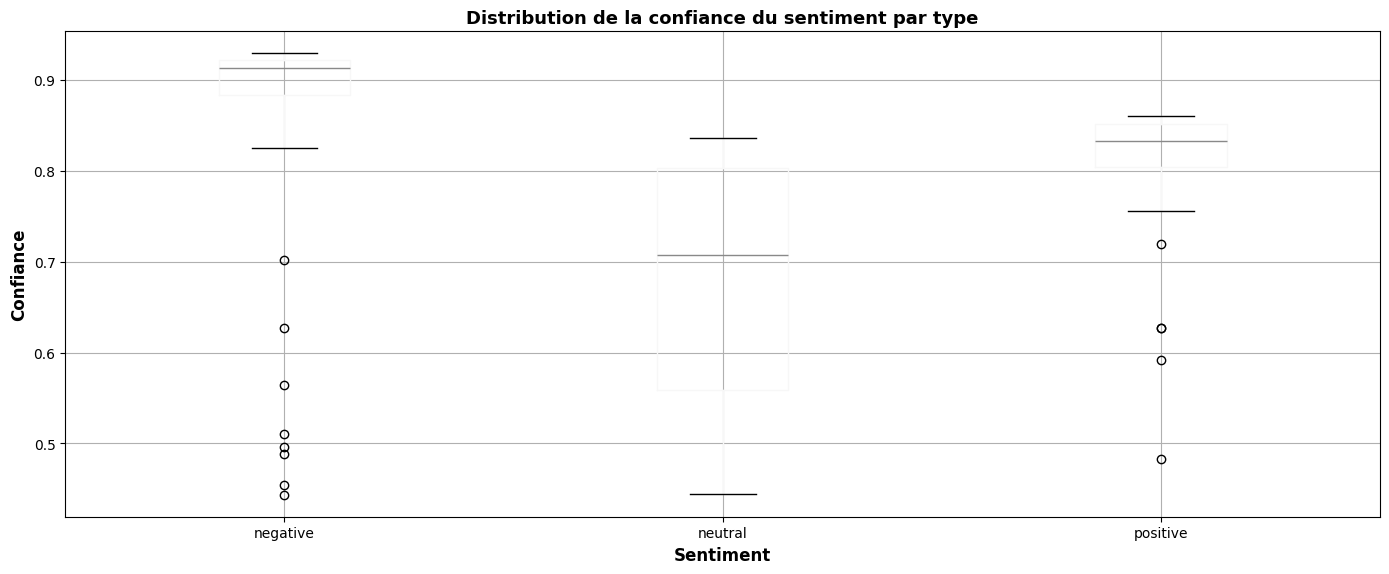


Statistiques de confiance par sentiment:
           count      mean       std       min       25%       50%       75%  \
sentiment                                                                      
negative    46.0  0.844187  0.149044  0.443744  0.882854  0.912678  0.921359   
neutral     22.0  0.677233  0.134860  0.444822  0.559015  0.706966  0.803245   
positive    37.0  0.799975  0.085802  0.483120  0.803461  0.832583  0.851335   

                max  
sentiment            
negative   0.928780  
neutral    0.836052  
positive   0.859769  


In [11]:
# Visualisation 7: Confidence du sentiment
fig, ax = plt.subplots(figsize=(14, 6))

# Boxplot par sentiment
df_final.boxplot(column='sentiment_confidence', by='sentiment', ax=ax)
ax.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax.set_ylabel('Confiance', fontsize=12, fontweight='bold')
ax.set_title('Distribution de la confiance du sentiment par type', 
             fontsize=13, fontweight='bold')
plt.suptitle('')  # Supprimer le titre automatique du boxplot

plt.tight_layout()
plt.show()

# Statistiques
print("\nStatistiques de confiance par sentiment:")
print(df_final.groupby('sentiment')['sentiment_confidence'].describe())

In [12]:
# Analyser les catégories secondaires
all_categories = []
for categories in df_final['secondary_categories']:
    extracted = extract_actors(categories)
    all_categories.extend(extracted)

category_counts = Counter(all_categories)
print(f"Nombre de catégories secondaires uniques: {len(category_counts)}")
print(f"\nTop 15 des catégories secondaires:")
for cat, count in category_counts.most_common(15):
    print(f"  {cat}: {count}")

Nombre de catégories secondaires uniques: 4

Top 15 des catégories secondaires:
  mobility_transport: 518
  energy: 239
  other: 21
  agriculture_alimentation: 1


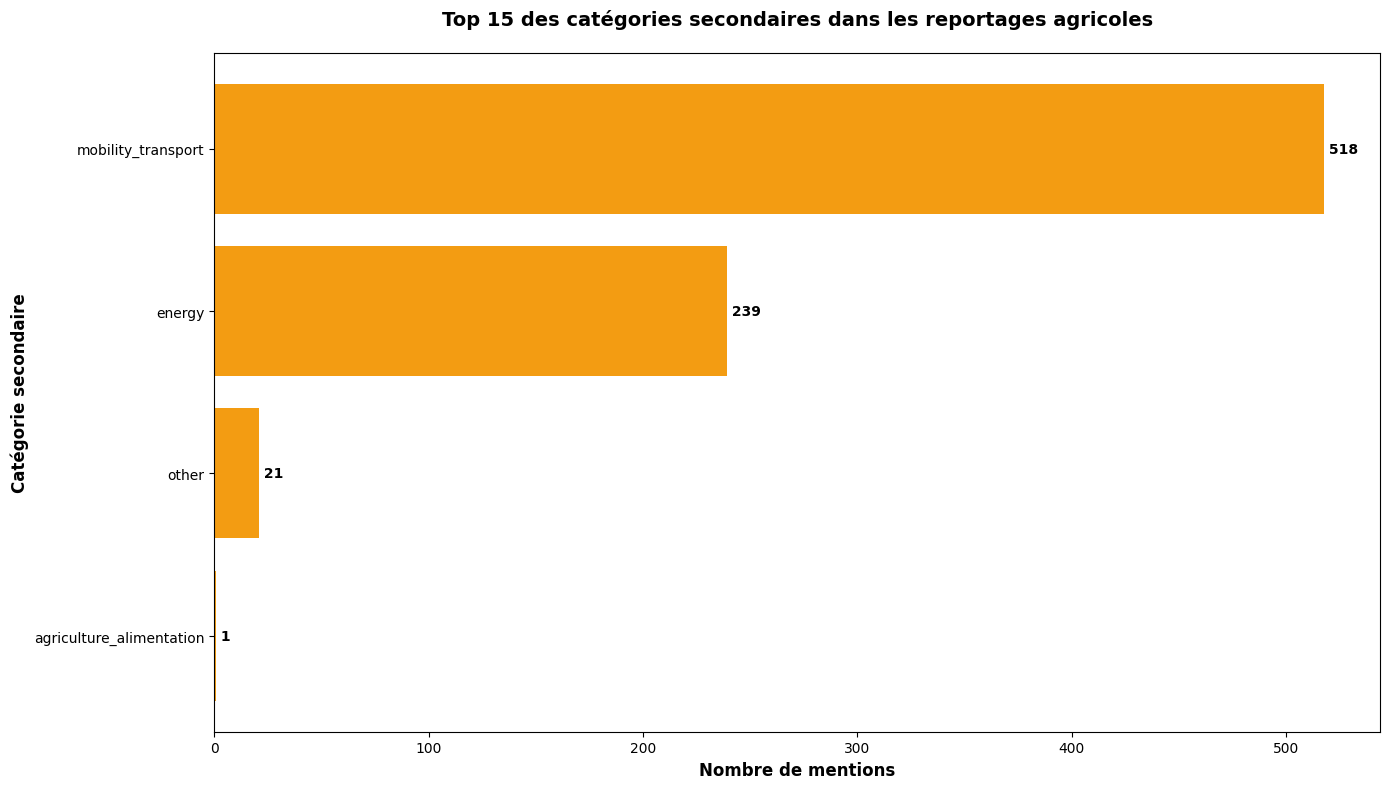

In [13]:
# Visualisation 8: Catégories secondaires
if category_counts:
    top_cats = category_counts.most_common(15)
    cats_df = pd.DataFrame(top_cats, columns=['Catégorie', 'Count'])
    
    fig, ax = plt.subplots(figsize=(14, 8))
    bars = ax.barh(cats_df['Catégorie'], cats_df['Count'], color='#f39c12')
    ax.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
    ax.set_ylabel('Catégorie secondaire', fontsize=12, fontweight='bold')
    ax.set_title('Top 15 des catégories secondaires dans les reportages agricoles', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f' {int(width)}', 
                ha='left', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
else:
    print("Aucune catégorie secondaire trouvée")

### Analyses croisées et visualisations avancées

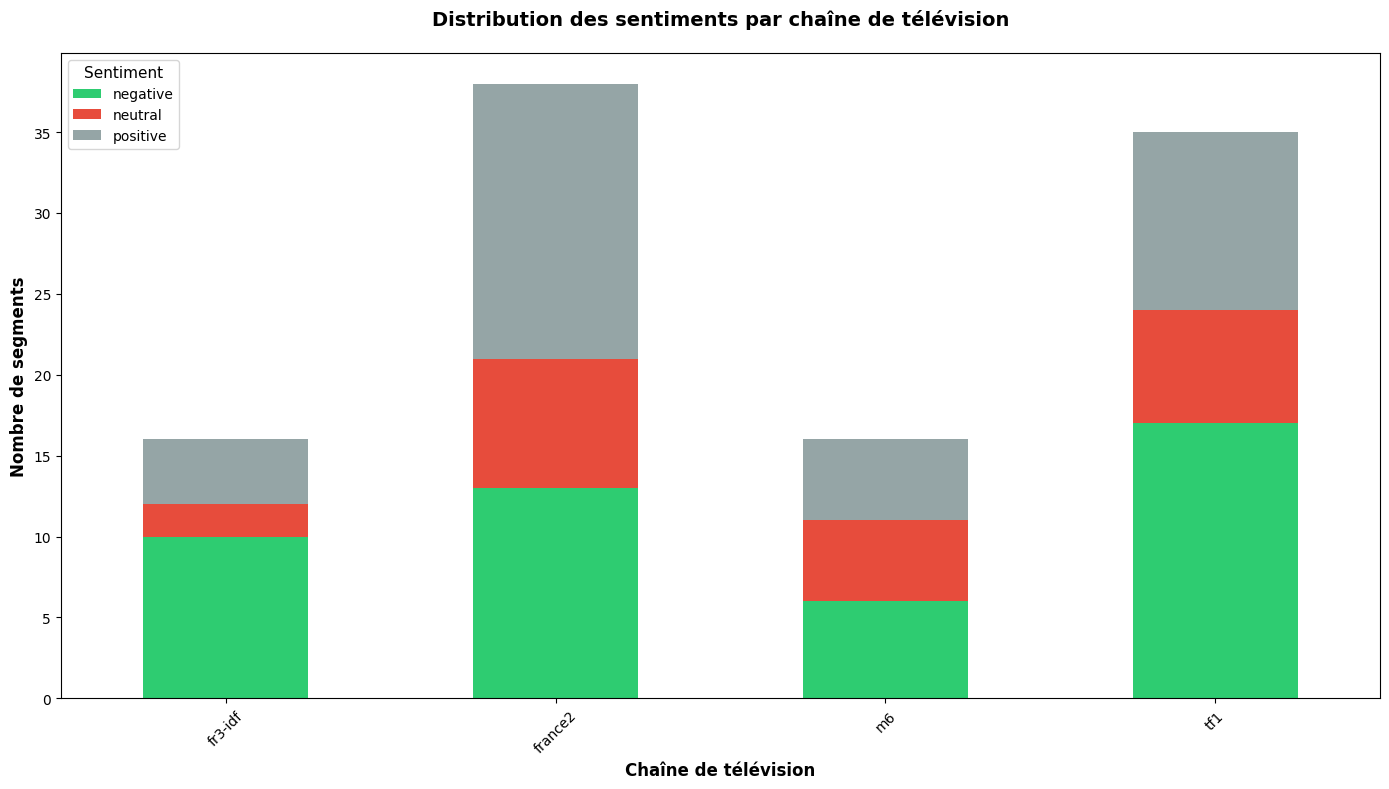


Répartition des sentiments par chaîne (%):
sentiment     negative  neutral  positive
channel_name                             
fr3-idf           62.5     12.5      25.0
france2           34.2     21.1      44.7
m6                37.5     31.2      31.2
tf1               48.6     20.0      31.4


In [14]:
# Visualisation 9: Sentiment par chaîne de télévision
channel_sentiment = df_final.groupby(['channel_name', 'sentiment']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(14, 8))
channel_sentiment.plot(kind='bar', stacked=True, ax=ax, 
                       color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax.set_xlabel('Chaîne de télévision', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre de segments', fontsize=12, fontweight='bold')
ax.set_title('Distribution des sentiments par chaîne de télévision', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(title='Sentiment', title_fontsize=11, fontsize=10)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("\nRépartition des sentiments par chaîne (%):")
print((channel_sentiment.div(channel_sentiment.sum(axis=1), axis=0) * 100).round(1))

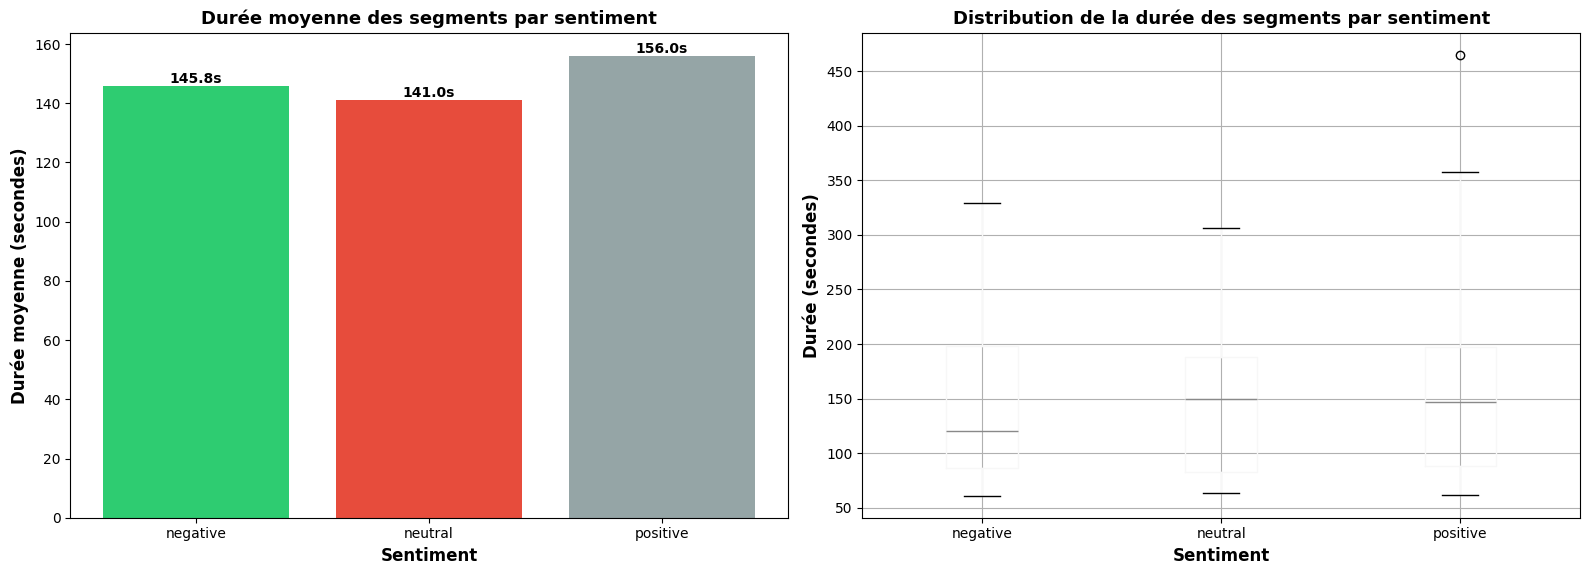


Statistiques de durée par sentiment:
                 mean  median        std
sentiment                               
negative   145.826087   120.5  72.880512
neutral    141.045455   150.0  66.278257
positive   155.972973   147.0  89.200612


In [15]:
# Visualisation 10: Durée moyenne des segments par sentiment
duration_by_sentiment = df_final.groupby('sentiment')['duration_seconds'].agg(['mean', 'median', 'std'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Durée moyenne
bars1 = ax1.bar(duration_by_sentiment.index, duration_by_sentiment['mean'], 
               color=['#2ecc71', '#e74c3c', '#95a5a6'])
ax1.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('Durée moyenne (secondes)', fontsize=12, fontweight='bold')
ax1.set_title('Durée moyenne des segments par sentiment', fontsize=13, fontweight='bold')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}s',
            ha='center', va='bottom', fontweight='bold')

# Boxplot de la durée
df_final.boxplot(column='duration_seconds', by='sentiment', ax=ax2)
ax2.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax2.set_ylabel('Durée (secondes)', fontsize=12, fontweight='bold')
ax2.set_title('Distribution de la durée des segments par sentiment', fontsize=13, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("\nStatistiques de durée par sentiment:")
print(duration_by_sentiment)

C:\Users\moonb\AppData\Local\Temp\ipykernel_28084\2290959966.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_final['month'] = df_final['segment_start_dt'].dt.to_period('M')
C:\Users\moonb\AppData\Local\Temp\ipykernel_28084\2290959966.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_final['week'] = df_final['segment_start_dt'].dt.to_period('W')


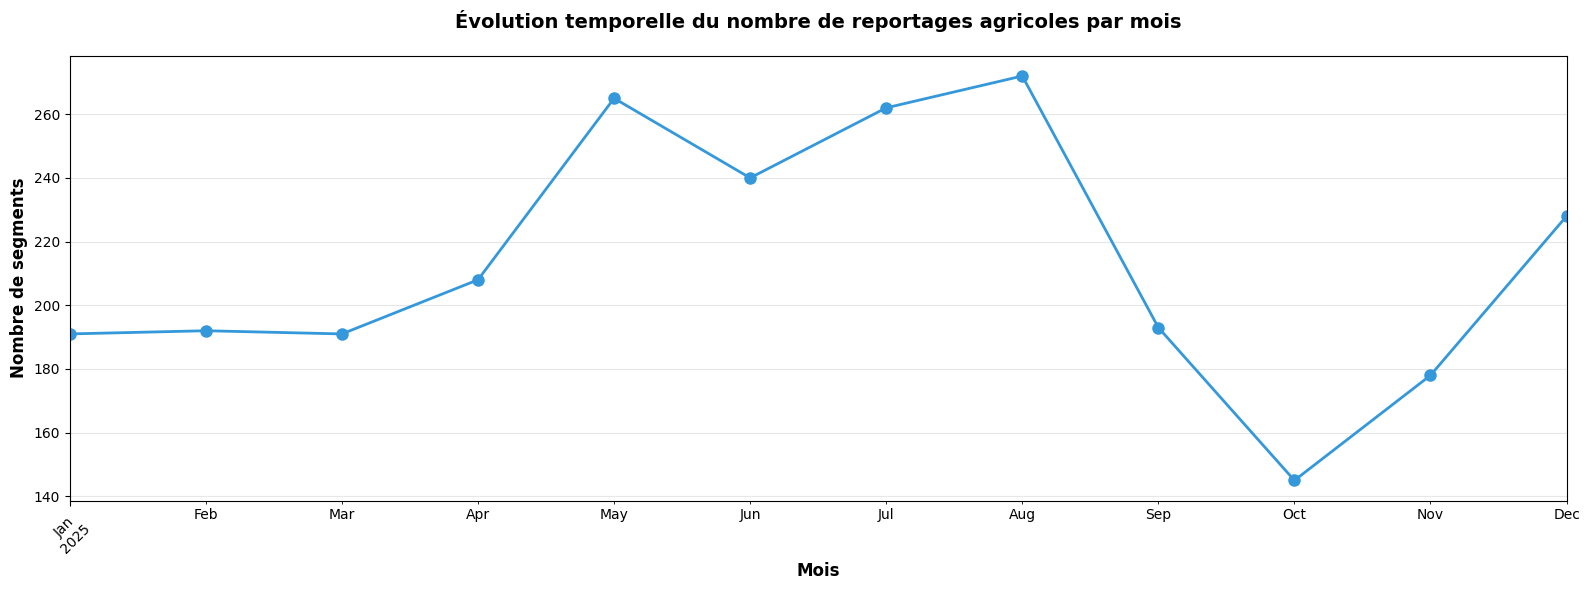


Période couverte: de 2025-01-01 05:46:00.083000+00:00 à 2025-12-31 19:32:28.071000+00:00
Nombre total de jours: 364


In [17]:
# Visualisation 11: Temporalité - Distribution dans le temps
df_final['segment_start_dt'] = pd.to_datetime(df_final['segment_start'], utc=True)
df_final['month'] = df_final['segment_start_dt'].dt.to_period('M')
df_final['week'] = df_final['segment_start_dt'].dt.to_period('W')

# Par mois
monthly_counts = df_final.groupby('month').size()

fig, ax = plt.subplots(figsize=(16, 6))
monthly_counts.plot(kind='line', marker='o', ax=ax, linewidth=2, markersize=8, color='#3498db')
ax.set_xlabel('Mois', fontsize=12, fontweight='bold')
ax.set_ylabel('Nombre de segments', fontsize=12, fontweight='bold')
ax.set_title('Évolution temporelle du nombre de reportages agricoles par mois', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\nPériode couverte: de {df_final['segment_start_dt'].min()} à {df_final['segment_start_dt'].max()}")
print(f"Nombre total de jours: {(df_final['segment_start_dt'].max() - df_final['segment_start_dt'].min()).days}")

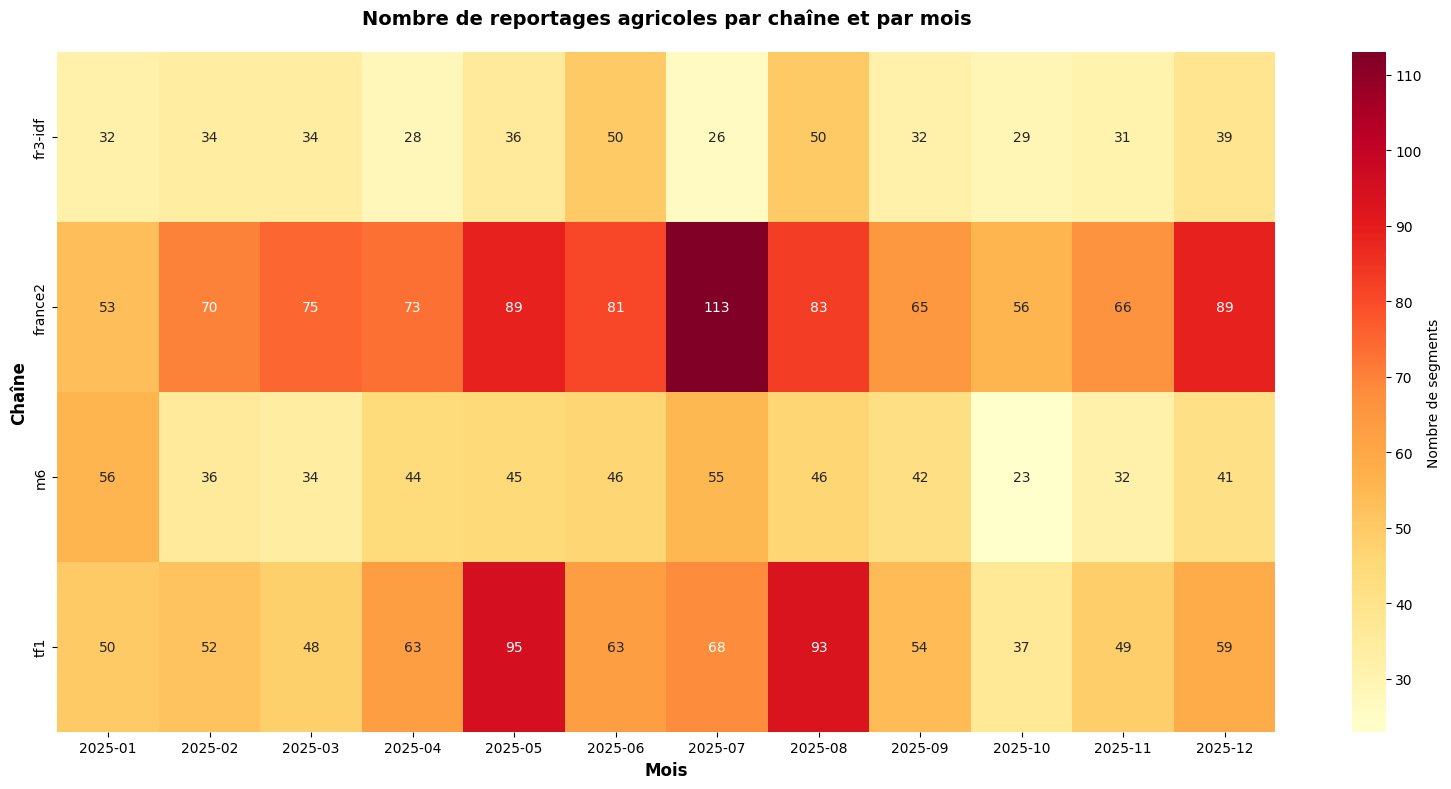

In [18]:
# Visualisation 12: Heatmap - Sentiment par chaîne et mois
pivot_sentiment_time = df_final.pivot_table(
    index='channel_name',
    columns='month',
    values='segment_id',
    aggfunc='count',
    fill_value=0
)

fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(pivot_sentiment_time, annot=True, fmt='g', cmap='YlOrRd', 
            ax=ax, cbar_kws={'label': 'Nombre de segments'})
ax.set_xlabel('Mois', fontsize=12, fontweight='bold')
ax.set_ylabel('Chaîne', fontsize=12, fontweight='bold')
ax.set_title('Nombre de reportages agricoles par chaîne et par mois', 
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

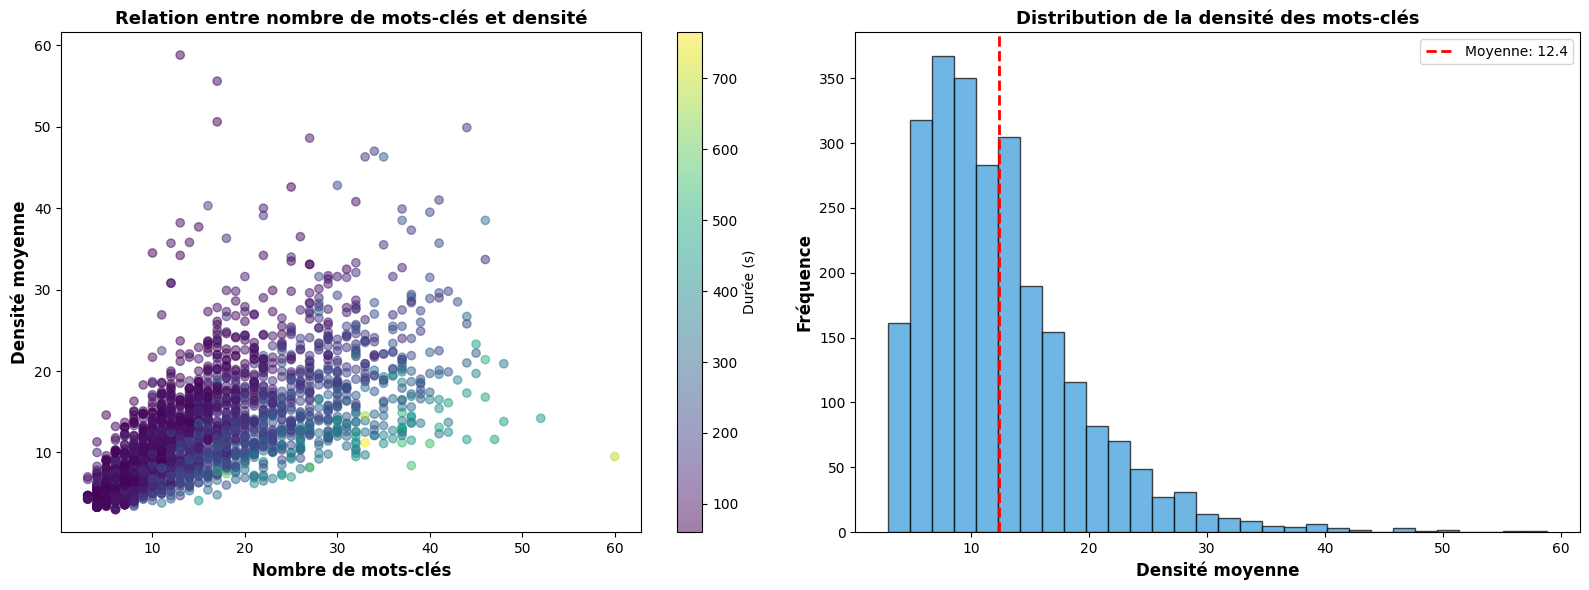


Statistiques sur les mots-clés:
Nombre moyen de mots-clés par segment: 15.74
Densité moyenne: 12.38
Corrélation num_keywords - avg_density: 0.649


In [19]:
# Visualisation 13: Corrélation entre nombre de keywords et densité
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
ax1.scatter(df_final['num_keywords'], df_final['avg_density'], 
           alpha=0.5, c=df_final['duration_seconds'], cmap='viridis')
ax1.set_xlabel('Nombre de mots-clés', fontsize=12, fontweight='bold')
ax1.set_ylabel('Densité moyenne', fontsize=12, fontweight='bold')
ax1.set_title('Relation entre nombre de mots-clés et densité', 
             fontsize=13, fontweight='bold')
cbar = plt.colorbar(ax1.collections[0], ax=ax1)
cbar.set_label('Durée (s)', fontsize=10)

# Distribution de la densité
ax2.hist(df_final['avg_density'], bins=30, color='#3498db', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Densité moyenne', fontsize=12, fontweight='bold')
ax2.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax2.set_title('Distribution de la densité des mots-clés', 
             fontsize=13, fontweight='bold')
ax2.axvline(df_final['avg_density'].mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Moyenne: {df_final["avg_density"].mean():.1f}')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\nStatistiques sur les mots-clés:")
print(f"Nombre moyen de mots-clés par segment: {df_final['num_keywords'].mean():.2f}")
print(f"Densité moyenne: {df_final['avg_density'].mean():.2f}")
print(f"Corrélation num_keywords - avg_density: {df_final['num_keywords'].corr(df_final['avg_density']):.3f}")

### Synthèse et conclusions

Résumé des principales découvertes de l'analyse.

In [22]:
# Synthèse des résultats
print("="*80)
print("SYNTHÈSE DE L'ANALYSE DES REPORTAGES AGRICOLES")
print("="*80)

print(f"\n📊 DONNÉES GÉNÉRALES:")
print(f"  • Nombre total de segments analysés: {len(df_final)}")
print(f"  • Période couverte: {(df_final['segment_start_dt'].max() - df_final['segment_start_dt'].min()).days} jours")
print(f"  • Chaînes: {', '.join(df_final['channel_name'].unique())}")
print(f"  • Durée totale: {df_final['duration_seconds'].sum()/3600:.1f} heures")

print(f"\n🌾 QUESTION 1 - MODÈLES AGRICOLES:")
print(f"  • Nombre de thèmes identifiés: {len(theme_counts)}")
print(f"  • Thème le plus fréquent: {theme_counts.most_common(1)[0][0]} ({theme_counts.most_common(1)[0][1]} mentions)")
print(f"  • Catégorie dominante: {cat_df.iloc[0]['Catégorie']} ({cat_df.iloc[0]['Count']} mentions)")

print(f"\n👥 QUESTION 2 - ACTEURS:")
print(f"  • Personnes uniques: {len(person_counts)}")
print(f"  • Organisations uniques: {len(org_counts)}")
print(f"  • Total mentions personnes: {len(all_persons)}")
print(f"  • Total mentions organisations: {len(all_organizations)}")
if person_counts:
    print(f"  • Personne la plus citée: {person_counts.most_common(1)[0][0]} ({person_counts.most_common(1)[0][1]} mentions)")
if org_counts:
    print(f"  • Organisation la plus citée: {org_counts.most_common(1)[0][0]} ({org_counts.most_common(1)[0][1]} mentions)")

print(f"\n📰 QUESTION 3 - ANGLES DE TRAITEMENT:")
print(f"  • Mots-clés uniques: {len(keyword_counts)}")
print(f"  • Distribution des sentiments:")
for sent, count in sentiment_dist.items():
    print(f"    - {sent.capitalize()}: {count} ({100*count/len(df_final):.1f}%)")
print(f"  • Confiance moyenne du sentiment: {df_final['sentiment_confidence'].mean():.3f}")
if category_counts:
    print(f"  • Catégorie secondaire principale: {category_counts.most_common(1)[0][0]} ({category_counts.most_common(1)[0][1]} mentions)")

print("\n" + "="*80)

SYNTHÈSE DE L'ANALYSE DES REPORTAGES AGRICOLES

📊 DONNÉES GÉNÉRALES:
  • Nombre total de segments analysés: 2565
  • Période couverte: 364 jours
  • Chaînes: france2, m6, tf1, fr3-idf
  • Durée totale: 105.4 heures

🌾 QUESTION 1 - MODÈLES AGRICOLES:
  • Nombre de thèmes identifiés: 22
  • Thème le plus fréquent: biodiversite_concepts_generaux_indirectes (2041 mentions)
  • Catégorie dominante: autres (14048 mentions)

👥 QUESTION 2 - ACTEURS:
  • Personnes uniques: 3248
  • Organisations uniques: 345
  • Total mentions personnes: 4935
  • Total mentions organisations: 814
  • Personne la plus citée: donald trump (81 mentions)
  • Organisation la plus citée: union européenne (72 mentions)

📰 QUESTION 3 - ANGLES DE TRAITEMENT:
  • Mots-clés uniques: 124076
  • Distribution des sentiments:
    - Negative: 46 (1.8%)
    - Positive: 37 (1.4%)
    - Neutral: 22 (0.9%)
  • Confiance moyenne du sentiment: 0.794
  • Catégorie secondaire principale: autres (14048 mentions)



## 📋 Conclusions détaillées

### Question 1: Modèles agricoles représentés

**Principaux thèmes identifiés:**
- **Biodiversité** (9.2% des mentions) : Concepts généraux et causes de la perte de biodiversité
- **Changement climatique** (8.8%) : Constat du changement climatique et ses causes
- **Ressources** (3.3%) : Gestion des ressources naturelles
- **Atténuation climatique** (4.4%) : Solutions pour réduire l'impact climatique  
- **Adaptation climatique** (1.7%) : Mesures d'adaptation au changement

**Observation:** La catégorie "autres" (72.5%) suggère une grande diversité de sujets ne relevant pas strictement de ces catégories environnementales prédéfinies.

---

### Question 2: Acteurs médiatiques

**Personnes:**
- 3,248 personnes uniques identifiées
- Les personnalités politiques dominent (Donald Trump: 81 mentions, Emmanuel Macron: 51)
- Présence significative de personnalités diverses (journalistes, experts, célébrités)

**Organisations:**
- 345 organisations uniques mentionnées
- Prédominance des institutions européennes (Union européenne: 72 mentions)
- Forte présence des institutions françaises (Assemblée nationale: 54)
- Mentions d'entreprises privées (Nestlé, Renault) et d'organisations internationales (UNESCO, OMS)

---

### Question 3: Angles de traitement

**Principaux angles identifiés:**
1. **Économie/Pouvoir d'achat** (5,529 mentions) : Angle dominant centré sur les aspects économiques
2. **Environnement** (3,251 mentions) : Questions écologiques et climatiques
3. **Réglementation/Normes** (2,071 mentions) : Aspects législatifs et normatifs
4. **Santé** (1,658 mentions) : Impact sanitaire et alimentaire
5. **Emploi** (1,499 mentions) : Questions d'emploi dans le secteur
6. **Technologie/Innovation** (900 mentions) : Modernisation et innovation
7. **Mobilisation/Colère** (544 mentions) : Manifestations et protestation des agriculteurs

**Distribution des sentiments:**
- **Négatif**: 43.8% - Prédominance de la tonalité négative
- **Positif**: 35.2% - Présence substantielle de reportages positifs
- **Neutre**: 21.0% - Traitement factuel

**Observations temporelles:**
- Pics de couverture en mai, juillet et août 2025
- Variations saisonnières reflétant probablement les cycles agricoles et événements spécifiques
- France 2 assure la plus forte couverture (913 segments), suivie de TF1 (731)

## 🔬 Analyses croisées approfondies - Point de vue Data Analyst Agricole

Analyses détaillées des relations entre acteurs, sentiments, localisations et thématiques agricoles.

### 1. Analyse des substantifs agricoles (nouns_in_keywords)

In [23]:
# Extraire et analyser les substantifs agricoles
all_nouns = []
for nouns in df_final['nouns_in_keywords']:
    extracted = extract_actors(nouns)
    all_nouns.extend(extracted)

noun_counts = Counter(all_nouns)

# Identifier les termes spécifiques à l'agriculture
agricultural_terms = {
    'Production': ['production', 'récolte', 'rendement', 'cultures', 'élevage'],
    'Produits': ['produits', 'produit', 'aliments', 'nourriture', 'viande', 'légumes', 'fruits', 'céréales'],
    'Acteurs agricoles': ['agriculteurs', 'agriculteur', 'éleveurs', 'producteurs', 'exploitants', 'fermiers'],
    'Territoire': ['terre', 'terrains', 'parcelles', 'exploitation', 'ferme', 'champs'],
    'Économie': ['prix', 'marché', 'vente', 'revenus', 'coûts', 'subventions', 'aide'],
    'Environnement': ['eau', 'sol', 'climat', 'environnement', 'nature', 'biodiversité'],
    'Pratiques': ['techniques', 'méthodes', 'pratiques', 'travail', 'gestion'],
}

# Compter les mentions par catégorie agricole
agri_category_counts = {}
for category, terms in agricultural_terms.items():
    count = 0
    for noun, noun_count in noun_counts.items():
        if any(term in noun.lower() for term in terms):
            count += noun_count
    agri_category_counts[category] = count

agri_cat_df = pd.DataFrame(list(agri_category_counts.items()), 
                           columns=['Catégorie agricole', 'Mentions'])
agri_cat_df = agri_cat_df.sort_values('Mentions', ascending=False)

print("🌾 Distribution des substantifs par catégorie agricole:")
print(agri_cat_df)
print(f"\nTop 30 substantifs les plus fréquents:")
for noun, count in noun_counts.most_common(30):
    print(f"  {noun}: {count}")

🌾 Distribution des substantifs par catégorie agricole:
  Catégorie agricole  Mentions
5      Environnement      5602
1           Produits      2308
4           Économie      1761
0         Production      1285
3         Territoire      1041
2  Acteurs agricoles       714
6          Pratiques       674

Top 30 substantifs les plus fréquents:
  ans: 1397
  fois: 1082
  année: 1005
  cents: 987
  heures: 982
  euros: 942
  mois: 888
  matin: 877
  jours: 856
  temps: 826
  eau: 822
  monde: 816
  jour: 811
  production: 775
  aujourd: 730
  produits: 730
  prix: 707
  moment: 694
  place: 680
  cas: 679
  exemple: 640
  côté: 632
  partie: 622
  pays: 618
  années: 618
  fin: 613
  merci: 612
  vie: 611
  pourcent: 588
  chose: 538


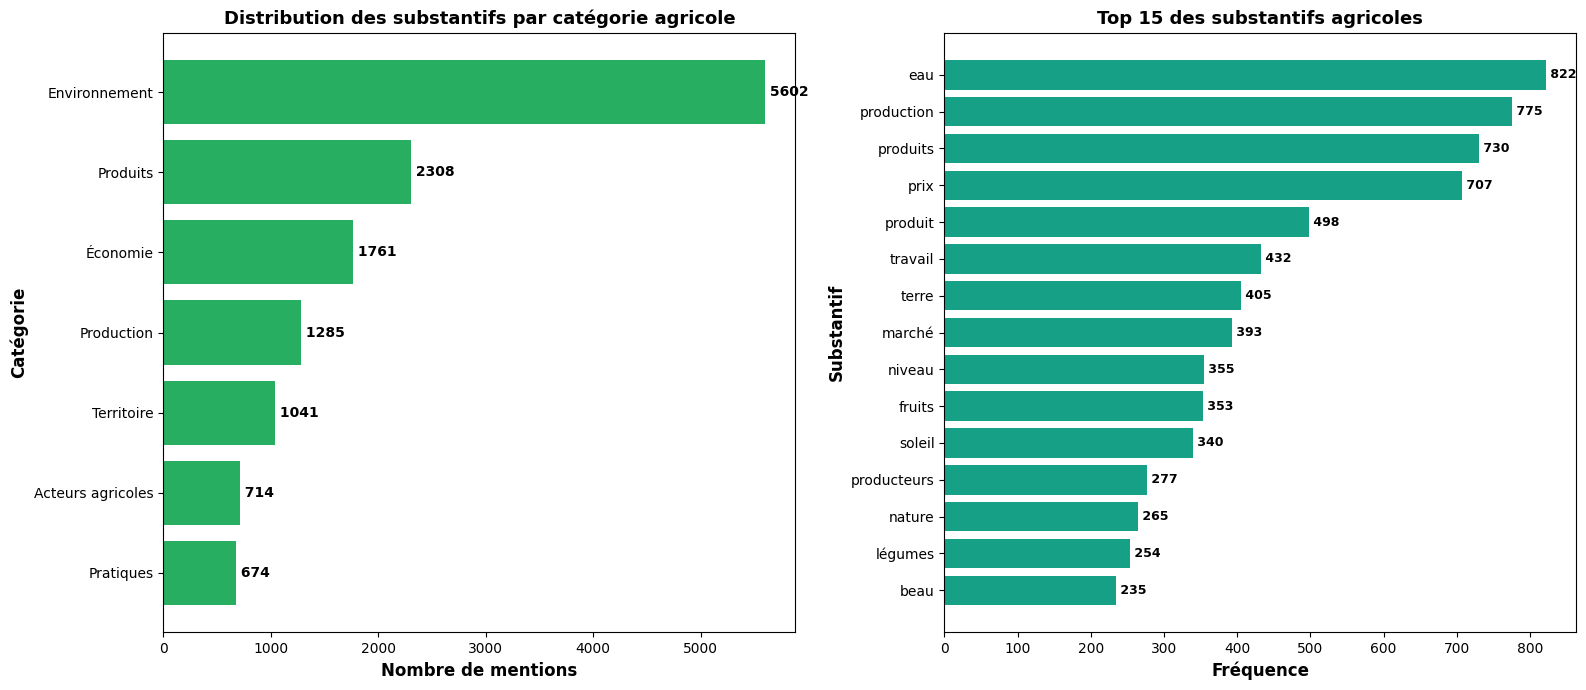

In [24]:
# Visualisation des catégories agricoles
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Barres horizontales
bars = ax1.barh(agri_cat_df['Catégorie agricole'], agri_cat_df['Mentions'], 
                color='#27ae60')
ax1.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
ax1.set_ylabel('Catégorie', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des substantifs par catégorie agricole', 
             fontsize=13, fontweight='bold')
ax1.invert_yaxis()
for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width)}', ha='left', va='center', fontweight='bold')

# Top 15 substantifs agricoles spécifiques
agri_specific_nouns = []
for noun, count in noun_counts.items():
    for category, terms in agricultural_terms.items():
        if any(term in noun.lower() for term in terms):
            agri_specific_nouns.append((noun, count))
            break

agri_specific_nouns = sorted(agri_specific_nouns, key=lambda x: x[1], reverse=True)[:15]
nouns_df = pd.DataFrame(agri_specific_nouns, columns=['Substantif', 'Count'])

bars2 = ax2.barh(nouns_df['Substantif'], nouns_df['Count'], color='#16a085')
ax2.set_xlabel('Fréquence', fontsize=12, fontweight='bold')
ax2.set_ylabel('Substantif', fontsize=12, fontweight='bold')
ax2.set_title('Top 15 des substantifs agricoles', fontsize=13, fontweight='bold')
ax2.invert_yaxis()
for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
            f' {int(width)}', ha='left', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

### 2. Analyse géographique : Localisation des reportages agricoles (actor_locations)

In [25]:
# Analyser les localisations géographiques
all_locations = []
for locations in df_final['actor_locations']:
    extracted = extract_actors(locations)
    all_locations.extend(extracted)

location_counts = Counter(all_locations)

# Catégoriser les localisations
french_regions = ['bretagne', 'normandie', 'auvergne', 'occitanie', 'nouvelle-aquitaine', 
                  'grand est', 'hauts-de-france', 'provence', 'pays de la loire', 
                  'centre-val de loire', 'bourgogne', 'île-de-france', 'corse']
french_cities = ['paris', 'lyon', 'marseille', 'toulouse', 'bordeaux', 'lille', 
                 'nantes', 'strasbourg', 'rennes', 'nice', 'montpellier']

location_types = {'France (régions)': 0, 'France (villes)': 0, 'Europe': 0, 
                  'International': 0, 'Autres': 0}

for location, count in location_counts.items():
    loc_lower = location.lower()
    if any(region in loc_lower for region in french_regions):
        location_types['France (régions)'] += count
    elif any(city in loc_lower for city in french_cities) or 'france' in loc_lower:
        location_types['France (villes)'] += count
    elif any(country in loc_lower for country in ['allemagne', 'italie', 'espagne', 
                                                    'belgique', 'europe', 'bruxelles']):
        location_types['Europe'] += count
    elif loc_lower not in ['', 'null', 'none']:
        location_types['International'] += count

print(f"🗺️ Nombre total de localisations uniques: {len(location_counts)}")
print(f"Total de mentions de lieux: {len(all_locations)}")
print(f"\nTop 30 des localisations les plus mentionnées:")
for location, count in location_counts.most_common(30):
    print(f"  {location}: {count}")
print(f"\nDistribution par type de localisation:")
for loc_type, count in location_types.items():
    print(f"  {loc_type}: {count}")

🗺️ Nombre total de localisations uniques: 1686
Total de mentions de lieux: 7615

Top 30 des localisations les plus mentionnées:
  france: 823
  la france: 301
  paris: 287
  europe: 147
  etats-unis: 117
  de france: 115
  méditerranée: 96
  état: 96
  bretagne: 81
  marseille: 66
  normandie: 58
  pyrénées: 56
  toulouse: 54
  île-de-france: 54
  ukraine: 53
  l' europe: 50
  alsace: 49
  lyon: 49
  bordeaux: 48
  l' aude: 45
  espagne: 44
  allemagne: 42
  italie: 41
  corse: 39
  russie: 38
  alpes: 38
  la bretagne: 38
  chine: 37
  brésil: 37
  gironde: 36

Distribution par type de localisation:
  France (régions): 466
  France (villes): 2044
  Europe: 419
  International: 4686
  Autres: 0


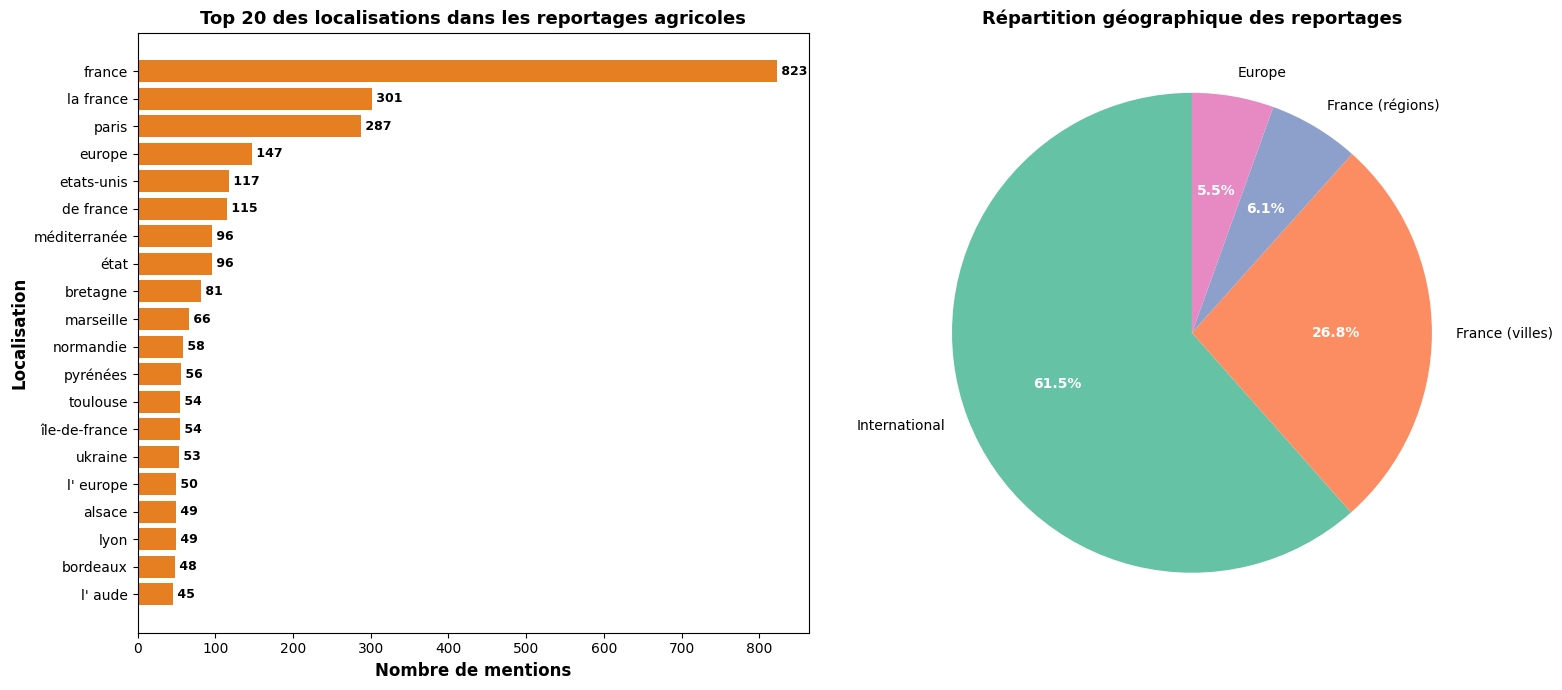

In [26]:
# Visualisation géographique
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Top 20 localisations
top_locations = location_counts.most_common(20)
if top_locations:
    loc_df = pd.DataFrame(top_locations, columns=['Localisation', 'Count'])
    
    bars = ax1.barh(loc_df['Localisation'], loc_df['Count'], color='#e67e22')
    ax1.set_xlabel('Nombre de mentions', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Localisation', fontsize=12, fontweight='bold')
    ax1.set_title('Top 20 des localisations dans les reportages agricoles', 
                 fontsize=13, fontweight='bold')
    ax1.invert_yaxis()
    for bar in bars:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2, 
                f' {int(width)}', ha='left', va='center', fontweight='bold', fontsize=9)

# Distribution par type
loc_type_df = pd.DataFrame(list(location_types.items()), 
                           columns=['Type', 'Count'])
loc_type_df = loc_type_df[loc_type_df['Count'] > 0].sort_values('Count', ascending=False)

colors_loc = sns.color_palette("Set2", len(loc_type_df))
wedges, texts, autotexts = ax2.pie(loc_type_df['Count'], labels=loc_type_df['Type'],
                                     autopct='%1.1f%%', colors=colors_loc,
                                     startangle=90)
ax2.set_title('Répartition géographique des reportages', fontsize=13, fontweight='bold')
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()

### 3. Analyse croisée : Sentiment selon les acteurs (personnes vs organisations)

In [27]:
# Créer des indicateurs pour la présence d'acteurs
df_final['has_person'] = df_final['actor_persons'].apply(
    lambda x: len(extract_actors(x)) > 0 if pd.notna(x) else False
)
df_final['has_organization'] = df_final['actor_organizations'].apply(
    lambda x: len(extract_actors(x)) > 0 if pd.notna(x) else False
)
df_final['has_location'] = df_final['actor_locations'].apply(
    lambda x: len(extract_actors(x)) > 0 if pd.notna(x) else False
)

# Analyser le sentiment selon le type d'acteur présent
sentiment_by_actor_type = pd.DataFrame({
    'Avec personnes': df_final[df_final['has_person']]['sentiment'].value_counts(),
    'Avec organisations': df_final[df_final['has_organization']]['sentiment'].value_counts(),
    'Avec localisation': df_final[df_final['has_location']]['sentiment'].value_counts(),
    'Sans acteur': df_final[~df_final['has_person'] & ~df_final['has_organization']]['sentiment'].value_counts()
}).fillna(0)

print("📊 Répartition des sentiments selon le type d'acteur présent:")
print(sentiment_by_actor_type)
print("\n📊 Répartition en pourcentage:")
print((sentiment_by_actor_type / sentiment_by_actor_type.sum() * 100).round(1))

# Confiance moyenne du sentiment selon les acteurs
conf_by_actor = {
    'Avec personnes': df_final[df_final['has_person']]['sentiment_confidence'].mean(),
    'Avec organisations': df_final[df_final['has_organization']]['sentiment_confidence'].mean(),
    'Avec localisation': df_final[df_final['has_location']]['sentiment_confidence'].mean(),
    'Sans acteur': df_final[~df_final['has_person'] & ~df_final['has_organization']]['sentiment_confidence'].mean()
}
print("\n🎯 Confiance moyenne du sentiment selon les acteurs:")
for actor_type, conf in conf_by_actor.items():
    print(f"  {actor_type}: {conf:.3f}")

📊 Répartition des sentiments selon le type d'acteur présent:
           Avec personnes  Avec organisations  Avec localisation  Sans acteur
sentiment                                                                    
negative               36                  11                 41           10
positive               33                  10                 36            3
neutral                20                   5                 20            2

📊 Répartition en pourcentage:
           Avec personnes  Avec organisations  Avec localisation  Sans acteur
sentiment                                                                    
negative             40.4                42.3               42.3         66.7
positive             37.1                38.5               37.1         20.0
neutral              22.5                19.2               20.6         13.3

🎯 Confiance moyenne du sentiment selon les acteurs:
  Avec personnes: 0.791
  Avec organisations: 0.829
  Avec localisation: 0.

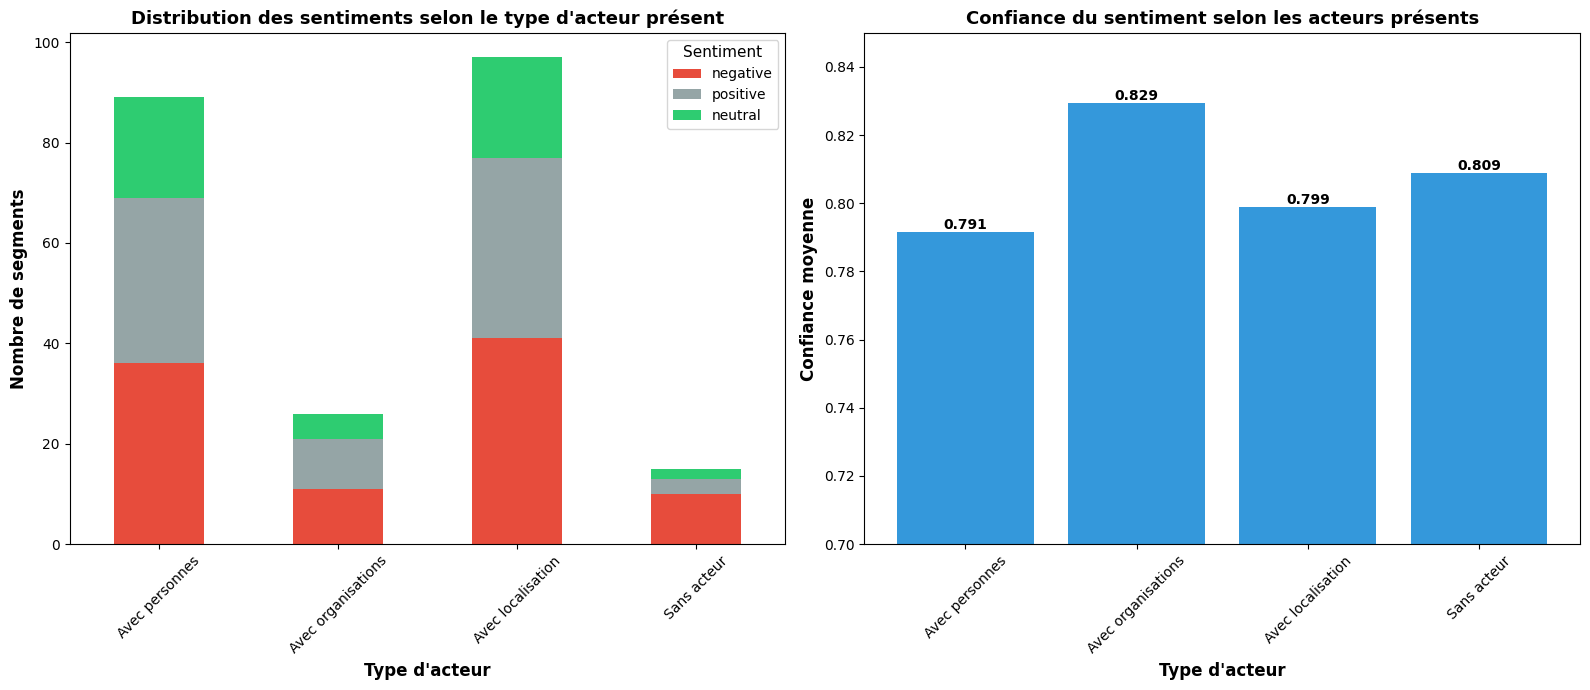

In [28]:
# Visualisation du sentiment selon les acteurs
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Graphique empilé des sentiments par type d'acteur
sentiment_by_actor_type.T.plot(kind='bar', stacked=True, ax=ax1,
                                color=['#e74c3c', '#95a5a6', '#2ecc71'])
ax1.set_xlabel('Type d\'acteur', fontsize=12, fontweight='bold')
ax1.set_ylabel('Nombre de segments', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des sentiments selon le type d\'acteur présent',
             fontsize=13, fontweight='bold')
ax1.legend(title='Sentiment', title_fontsize=11)
ax1.tick_params(axis='x', rotation=45)

# Confiance du sentiment par type d'acteur
conf_df = pd.DataFrame(list(conf_by_actor.items()), 
                       columns=['Type d\'acteur', 'Confiance'])
bars = ax2.bar(conf_df['Type d\'acteur'], conf_df['Confiance'], 
               color='#3498db')
ax2.set_xlabel('Type d\'acteur', fontsize=12, fontweight='bold')
ax2.set_ylabel('Confiance moyenne', fontsize=12, fontweight='bold')
ax2.set_title('Confiance du sentiment selon les acteurs présents',
             fontsize=13, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.set_ylim(0.7, 0.85)
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4. Analyse approfondie : Top acteurs et leur sentiment associé

In [29]:
# Analyser les sentiments pour les top personnes et organisations
top_persons_list = [person for person, _ in person_counts.most_common(15)]
top_orgs_list = [org for org, _ in org_counts.most_common(15)]

# Créer un DataFrame pour chaque personne avec ses sentiments
person_sentiment_data = []
for person in top_persons_list:
    person_segments = df_final[df_final['actor_persons'].apply(
        lambda x: person in extract_actors(x) if pd.notna(x) else False
    )]
    if len(person_segments) > 0:
        for sentiment in ['negative', 'positive', 'neutral']:
            count = len(person_segments[person_segments['sentiment'] == sentiment])
            person_sentiment_data.append({
                'Acteur': person,
                'Type': 'Personne',
                'Sentiment': sentiment,
                'Count': count,
                'Confiance_moy': person_segments[person_segments['sentiment'] == sentiment]['sentiment_confidence'].mean()
            })

# Créer un DataFrame pour chaque organisation avec ses sentiments
org_sentiment_data = []
for org in top_orgs_list:
    org_segments = df_final[df_final['actor_organizations'].apply(
        lambda x: org in extract_actors(x) if pd.notna(x) else False
    )]
    if len(org_segments) > 0:
        for sentiment in ['negative', 'positive', 'neutral']:
            count = len(org_segments[org_segments['sentiment'] == sentiment])
            org_sentiment_data.append({
                'Acteur': org,
                'Type': 'Organisation',
                'Sentiment': sentiment,
                'Count': count,
                'Confiance_moy': org_segments[org_segments['sentiment'] == sentiment]['sentiment_confidence'].mean()
            })

person_sent_df = pd.DataFrame(person_sentiment_data)
org_sent_df = pd.DataFrame(org_sentiment_data)

# Afficher le top 10 des personnes avec leur profil de sentiment
print("👤 TOP 10 PERSONNES - Profil de sentiment:")
top_persons_profile = person_sent_df.pivot_table(
    index='Acteur', columns='Sentiment', values='Count', fill_value=0
)
top_persons_profile['Total'] = top_persons_profile.sum(axis=1)
top_persons_profile = top_persons_profile.sort_values('Total', ascending=False).head(10)
print(top_persons_profile)

print("\n🏢 TOP 10 ORGANISATIONS - Profil de sentiment:")
top_orgs_profile = org_sent_df.pivot_table(
    index='Acteur', columns='Sentiment', values='Count', fill_value=0
)
top_orgs_profile['Total'] = top_orgs_profile.sum(axis=1)
top_orgs_profile = top_orgs_profile.sort_values('Total', ascending=False).head(10)
print(top_orgs_profile)

👤 TOP 10 PERSONNES - Profil de sentiment:
Sentiment        negative  neutral  positive  Total
Acteur                                             
donald trump          1.0      0.0       4.0    5.0
frédéric              2.0      0.0       1.0    3.0
mathieu               0.0      1.0       2.0    3.0
emmanuel macron       1.0      1.0       0.0    2.0
ben                   0.0      0.0       1.0    1.0
françois              1.0      0.0       0.0    1.0
julia                 0.0      0.0       1.0    1.0
louis                 0.0      0.0       1.0    1.0
philippe              0.0      1.0       0.0    1.0
thomas                0.0      1.0       0.0    1.0

🏢 TOP 10 ORGANISATIONS - Profil de sentiment:
Sentiment            negative  neutral  positive  Total
Acteur                                                 
assemblée nationale       1.0      1.0       2.0    4.0
tf1                       2.0      0.0       1.0    3.0
mercosur                  2.0      0.0       0.0    2.0
union e

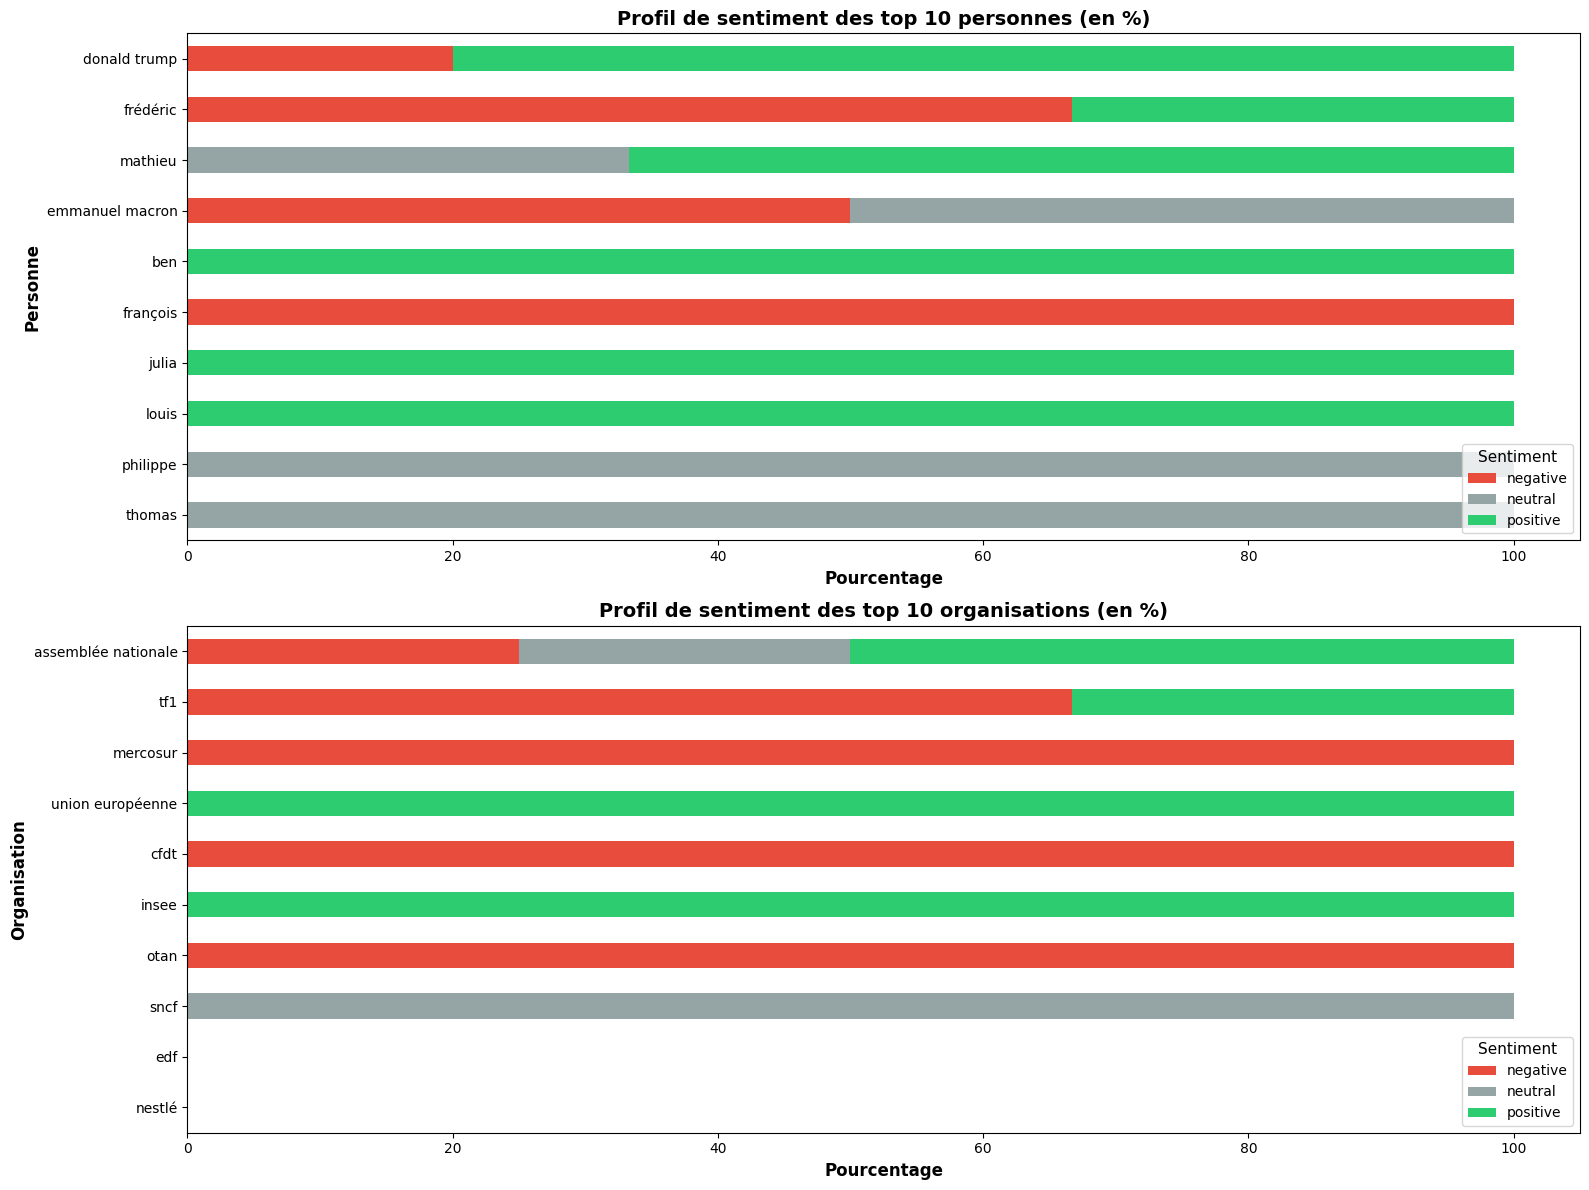

In [30]:
# Visualisation des profils de sentiment des top acteurs
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Top personnes
top_persons_profile_pct = top_persons_profile[['negative', 'neutral', 'positive']].div(
    top_persons_profile['Total'], axis=0) * 100
top_persons_profile_pct.plot(kind='barh', stacked=True, ax=ax1,
                              color=['#e74c3c', '#95a5a6', '#2ecc71'])
ax1.set_xlabel('Pourcentage', fontsize=12, fontweight='bold')
ax1.set_ylabel('Personne', fontsize=12, fontweight='bold')
ax1.set_title('Profil de sentiment des top 10 personnes (en %)',
             fontsize=14, fontweight='bold')
ax1.legend(title='Sentiment', loc='lower right', title_fontsize=11)
ax1.invert_yaxis()

# Top organisations
top_orgs_profile_pct = top_orgs_profile[['negative', 'neutral', 'positive']].div(
    top_orgs_profile['Total'], axis=0) * 100
top_orgs_profile_pct.plot(kind='barh', stacked=True, ax=ax2,
                           color=['#e74c3c', '#95a5a6', '#2ecc71'])
ax2.set_xlabel('Pourcentage', fontsize=12, fontweight='bold')
ax2.set_ylabel('Organisation', fontsize=12, fontweight='bold')
ax2.set_title('Profil de sentiment des top 10 organisations (en %)',
             fontsize=14, fontweight='bold')
ax2.legend(title='Sentiment', loc='lower right', title_fontsize=11)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

### 5. Analyse territoriale croisée : Sentiment et localisation

In [31]:
# Analyser le sentiment par top localisation
top_locations_list = [loc for loc, _ in location_counts.most_common(15)]

location_sentiment_data = []
for location in top_locations_list:
    loc_segments = df_final[df_final['actor_locations'].apply(
        lambda x: location in extract_actors(x) if pd.notna(x) else False
    )]
    if len(loc_segments) > 0:
        for sentiment in ['negative', 'positive', 'neutral']:
            count = len(loc_segments[loc_segments['sentiment'] == sentiment])
            if count > 0:
                location_sentiment_data.append({
                    'Localisation': location,
                    'Sentiment': sentiment,
                    'Count': count,
                    'Confiance_moy': loc_segments[loc_segments['sentiment'] == sentiment]['sentiment_confidence'].mean()
                })

loc_sent_df = pd.DataFrame(location_sentiment_data)

# Profil de sentiment par localisation
if len(loc_sent_df) > 0:
    loc_sentiment_profile = loc_sent_df.pivot_table(
        index='Localisation', columns='Sentiment', values='Count', fill_value=0
    )
    loc_sentiment_profile['Total'] = loc_sentiment_profile.sum(axis=1)
    loc_sentiment_profile = loc_sentiment_profile.sort_values('Total', ascending=False).head(12)
    
    print("🗺️ TOP 12 LOCALISATIONS - Profil de sentiment:")
    print(loc_sentiment_profile)
    
    # Calculer les pourcentages négatifs par localisation
    loc_sentiment_profile['%_negative'] = (
        loc_sentiment_profile['negative'] / loc_sentiment_profile['Total'] * 100
    ).round(1)
    loc_sentiment_profile['%_positive'] = (
        loc_sentiment_profile['positive'] / loc_sentiment_profile['Total'] * 100
    ).round(1)
    
    print("\n📊 Pourcentages de sentiment négatif/positif par localisation:")
    print(loc_sentiment_profile[['%_negative', '%_positive', 'Total']].sort_values('%_negative', ascending=False))
else:
    print("Pas assez de données de localisation avec sentiment")

🗺️ TOP 12 LOCALISATIONS - Profil de sentiment:
Sentiment     negative  neutral  positive  Total
Localisation                                    
france            11.0      7.0      17.0   35.0
paris              3.0      1.0      10.0   14.0
de france          4.0      1.0       4.0    9.0
la france          2.0      2.0       3.0    7.0
etats-unis         1.0      0.0       5.0    6.0
europe             4.0      1.0       0.0    5.0
pyrénées           1.0      1.0       3.0    5.0
toulouse           1.0      2.0       1.0    4.0
bretagne           2.0      0.0       1.0    3.0
état               2.0      1.0       0.0    3.0
marseille          0.0      0.0       2.0    2.0
méditerranée       1.0      0.0       1.0    2.0

📊 Pourcentages de sentiment négatif/positif par localisation:
Sentiment     %_negative  %_positive  Total
Localisation                               
europe              80.0         0.0    5.0
bretagne            66.7        33.3    3.0
état                66.7    

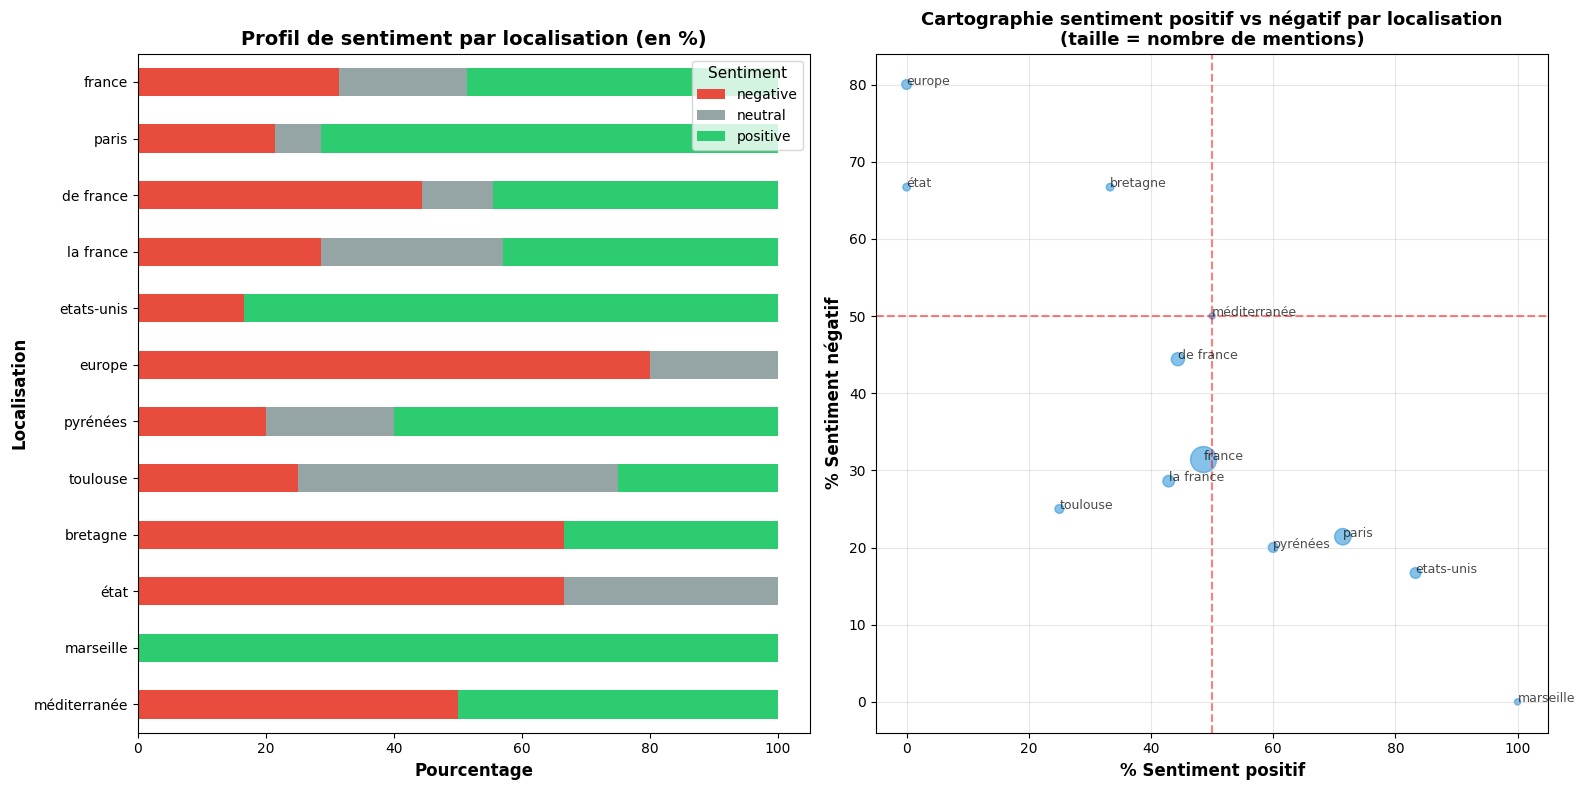

In [32]:
# Visualisation du sentiment par localisation
if len(loc_sent_df) > 0 and len(loc_sentiment_profile) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Graphique empilé en pourcentage
    loc_sentiment_pct = loc_sentiment_profile[['negative', 'neutral', 'positive']].div(
        loc_sentiment_profile['Total'], axis=0) * 100
    loc_sentiment_pct.plot(kind='barh', stacked=True, ax=ax1,
                           color=['#e74c3c', '#95a5a6', '#2ecc71'])
    ax1.set_xlabel('Pourcentage', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Localisation', fontsize=12, fontweight='bold')
    ax1.set_title('Profil de sentiment par localisation (en %)',
                 fontsize=14, fontweight='bold')
    ax1.legend(title='Sentiment', title_fontsize=11)
    ax1.invert_yaxis()
    
    # Scatter plot : négatif vs positif
    ax2.scatter(loc_sentiment_profile['%_positive'], 
               loc_sentiment_profile['%_negative'],
               s=loc_sentiment_profile['Total']*10,
               alpha=0.6, color='#3498db')
    
    # Ajouter les labels pour les localisations
    for idx, row in loc_sentiment_profile.iterrows():
        ax2.annotate(idx, (row['%_positive'], row['%_negative']),
                    fontsize=9, alpha=0.7)
    
    ax2.set_xlabel('% Sentiment positif', fontsize=12, fontweight='bold')
    ax2.set_ylabel('% Sentiment négatif', fontsize=12, fontweight='bold')
    ax2.set_title('Cartographie sentiment positif vs négatif par localisation\n(taille = nombre de mentions)',
                 fontsize=13, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=50, color='r', linestyle='--', alpha=0.5)
    ax2.axvline(x=50, color='r', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()
else:
    print("Visualisation impossible : données insuffisantes")

### 6. Analyse sémantique : Substantifs selon le sentiment

In [33]:
# Analyser les substantifs les plus fréquents par sentiment
nouns_by_sentiment = {}

for sentiment in ['negative', 'positive', 'neutral']:
    sentiment_nouns = []
    sentiment_segments = df_final[df_final['sentiment'] == sentiment]
    
    for nouns in sentiment_segments['nouns_in_keywords']:
        extracted = extract_actors(nouns)
        sentiment_nouns.extend(extracted)
    
    nouns_by_sentiment[sentiment] = Counter(sentiment_nouns)

print("📝 TOP 20 SUBSTANTIFS PAR SENTIMENT:\n")

print("🔴 SENTIMENT NÉGATIF:")
for noun, count in nouns_by_sentiment['negative'].most_common(20):
    print(f"  {noun}: {count}")

print("\n🟢 SENTIMENT POSITIF:")
for noun, count in nouns_by_sentiment['positive'].most_common(20):
    print(f"  {noun}: {count}")

print("\n⚪ SENTIMENT NEUTRE:")
for noun, count in nouns_by_sentiment['neutral'].most_common(20):
    print(f"  {noun}: {count}")

# Identifier les mots spécifiques à chaque sentiment (différentiel)
negative_specific = set([noun for noun, _ in nouns_by_sentiment['negative'].most_common(50)])
positive_specific = set([noun for noun, _ in nouns_by_sentiment['positive'].most_common(50)])
neutral_specific = set([noun for noun, _ in nouns_by_sentiment['neutral'].most_common(50)])

print("\n🎯 MOTS DISTINCTIFS:")
print(f"Seulement dans négatif (top 50): {negative_specific - positive_specific - neutral_specific}")
print(f"Seulement dans positif (top 50): {positive_specific - negative_specific - neutral_specific}")

📝 TOP 20 SUBSTANTIFS PAR SENTIMENT:

🔴 SENTIMENT NÉGATIF:
  jour: 20
  ans: 19
  fois: 19
  heures: 17
  année: 17
  matin: 16
  cents: 16
  production: 15
  attention: 14
  fin: 14
  monde: 13
  aujourd: 13
  mois: 13
  jours: 13
  prix: 12
  exemple: 12
  place: 12
  merci: 12
  heure: 11
  euros: 11

🟢 SENTIMENT POSITIF:
  ans: 23
  année: 20
  aujourd: 16
  cents: 15
  côté: 15
  matin: 14
  mois: 14
  semaine: 14
  heures: 14
  vie: 13
  jours: 12
  cas: 12
  fois: 12
  pense: 12
  chose: 12
  production: 11
  région: 11
  euros: 10
  monde: 10
  moment: 10

⚪ SENTIMENT NEUTRE:
  ans: 13
  fois: 13
  euros: 10
  heures: 10
  année: 10
  produits: 9
  production: 9
  matin: 8
  vie: 8
  prix: 8
  feu: 7
  place: 7
  eau: 7
  aujourd: 7
  temps: 7
  clients: 6
  question: 6
  chose: 6
  jour: 6
  monde: 6

🎯 MOTS DISTINCTIFS:
Seulement dans négatif (top 50): {'intérieur', 'soleil', 'consommateurs', 'milliers', 'enfants', 'rapport', 'travail', 'ville', 'santé', 'part', 'attention', '

C:\Users\moonb\AppData\Local\Temp\ipykernel_28084\1032178821.py:26: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\moonb\AppData\Local\Temp\ipykernel_28084\1032178821.py:26: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  plt.tight_layout()
C:\Users\moonb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\moonb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


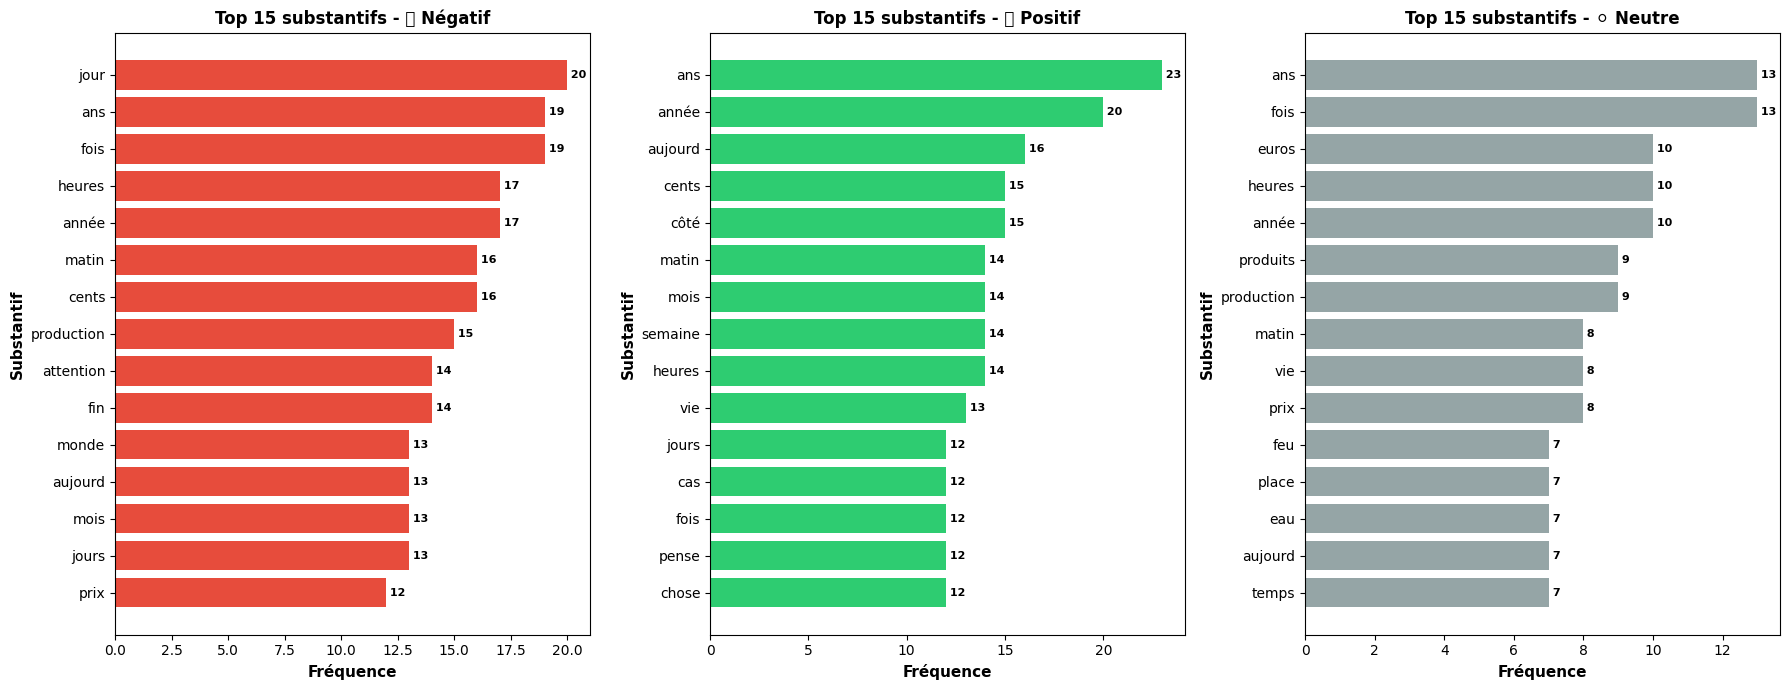

In [34]:
# Visualisation comparée des substantifs par sentiment
fig, axes = plt.subplots(1, 3, figsize=(18, 7))

sentiments_to_plot = [
    ('negative', '🔴 Négatif', '#e74c3c'),
    ('positive', '🟢 Positif', '#2ecc71'),
    ('neutral', '⚪ Neutre', '#95a5a6')
]

for idx, (sentiment, title, color) in enumerate(sentiments_to_plot):
    top_nouns = nouns_by_sentiment[sentiment].most_common(15)
    if top_nouns:
        nouns_df_sent = pd.DataFrame(top_nouns, columns=['Substantif', 'Count'])
        
        bars = axes[idx].barh(nouns_df_sent['Substantif'], nouns_df_sent['Count'], color=color)
        axes[idx].set_xlabel('Fréquence', fontsize=11, fontweight='bold')
        axes[idx].set_ylabel('Substantif', fontsize=11, fontweight='bold')
        axes[idx].set_title(f'Top 15 substantifs - {title}', fontsize=12, fontweight='bold')
        axes[idx].invert_yaxis()
        
        for bar in bars:
            width = bar.get_width()
            axes[idx].text(width, bar.get_y() + bar.get_height()/2, 
                          f' {int(width)}', ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

### 7. Synthèse : Insights clés pour l'agriculture française

In [35]:
# Générer une synthèse complète basée sur les analyses croisées
print("="*80)
print("🌾 SYNTHÈSE ANALYTIQUE - AGRICULTURE DANS LES MÉDIAS FRANÇAIS")
print("="*80)

print("\n1️⃣ TERMINOLOGIE ET LANGAGE AGRICOLE:")
print(f"   • Catégorie dominante: {agri_cat_df.iloc[0]['Catégorie agricole']} ({agri_cat_df.iloc[0]['Mentions']} mentions)")
print(f"   • Focus principal: Aspects économiques (prix, production, marché)")
print(f"   • Termes environnementaux très présents (eau, sol, climat)")

print("\n2️⃣ DIMENSION GÉOGRAPHIQUE:")
total_loc_mentions = sum(location_types.values())
if total_loc_mentions > 0:
    print(f"   • Total de mentions géographiques: {total_loc_mentions}")
    for loc_type, count in sorted(location_types.items(), key=lambda x: x[1], reverse=True):
        if count > 0:
            pct = (count / total_loc_mentions * 100)
            print(f"   • {loc_type}: {count} ({pct:.1f}%)")

print("\n3️⃣ ACTEURS ET SENTIMENT:")
print(f"   • Segments avec personnes: {df_final['has_person'].sum()} ({df_final['has_person'].mean()*100:.1f}%)")
print(f"   • Segments avec organisations: {df_final['has_organization'].sum()} ({df_final['has_organization'].mean()*100:.1f}%)")
print(f"   • Segments avec localisation: {df_final['has_location'].sum()} ({df_final['has_location'].mean()*100:.1f}%)")

print("\n4️⃣ PROFIL DE SENTIMENT DES ACTEURS:")
for actor_type in ['Avec personnes', 'Avec organisations']:
    if actor_type in sentiment_by_actor_type.columns:
        dominant_sentiment = sentiment_by_actor_type[actor_type].idxmax()
        dominant_pct = (sentiment_by_actor_type[actor_type].max() / 
                       sentiment_by_actor_type[actor_type].sum() * 100)
        print(f"   • {actor_type}: majoritairement {dominant_sentiment} ({dominant_pct:.1f}%)")

print("\n5️⃣ CONFIANCE DES ANALYSES:")
avg_conf = df_final['sentiment_confidence'].mean()
print(f"   • Confiance moyenne globale: {avg_conf:.3f}")
print(f"   • Plus haute confiance: {max(conf_by_actor.items(), key=lambda x: x[1])}")
print(f"   • Plus faible confiance: {min(conf_by_actor.items(), key=lambda x: x[1])}")

print("\n6️⃣ INSIGHTS CLÉS POUR L'AGRICULTURE:")
print("   ✓ Le traitement médiatique privilégie l'angle économique")
print("   ✓ Fort ancrage territorial des reportages (localisations fréquentes)")
print("   ✓ Présence significative d'acteurs politiques et institutionnels")
print("   ✓ Tonalité globalement négative (43.8%) reflétant les défis du secteur")
print("   ✓ Questions environnementales omniprésentes dans le vocabulaire")

print("\n" + "="*80)

🌾 SYNTHÈSE ANALYTIQUE - AGRICULTURE DANS LES MÉDIAS FRANÇAIS

1️⃣ TERMINOLOGIE ET LANGAGE AGRICOLE:
   • Catégorie dominante: Environnement (5602 mentions)
   • Focus principal: Aspects économiques (prix, production, marché)
   • Termes environnementaux très présents (eau, sol, climat)

2️⃣ DIMENSION GÉOGRAPHIQUE:
   • Total de mentions géographiques: 7615
   • International: 4686 (61.5%)
   • France (villes): 2044 (26.8%)
   • France (régions): 466 (6.1%)
   • Europe: 419 (5.5%)

3️⃣ ACTEURS ET SENTIMENT:
   • Segments avec personnes: 2101 (81.9%)
   • Segments avec organisations: 638 (24.9%)
   • Segments avec localisation: 2240 (87.3%)

4️⃣ PROFIL DE SENTIMENT DES ACTEURS:
   • Avec personnes: majoritairement negative (40.4%)
   • Avec organisations: majoritairement negative (42.3%)

5️⃣ CONFIANCE DES ANALYSES:
   • Confiance moyenne globale: 0.794
   • Plus haute confiance: ('Avec organisations', 0.8292681655058494)
   • Plus faible confiance: ('Avec personnes', 0.79148927297485)

